# ARIMA Model

# 1. Introduction

This notebook contains an Auto-Regression Integrated Moving Average (ARIMA) model to forecast the close prices of crude oil.

# 2. Imports

In [7]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


# Statsmodels imports
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf, adfuller
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

# Evaluation imports
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [8]:
warnings.filterwarnings('ignore')

# 3. Import Data

In [33]:
#df = pd.read_csv("m5barreport270923.csv",index_col=0,parse_dates=True)
df = pd.read_csv("m5barreport310823.csv",index_col=0,parse_dates=True)
df.index.freq = '5T'

In [34]:
df.head()

,Date,Time,Volume,Open,High,Low,Close,Market
Datetime,,,,,,,,
2023-07-17 00:05:00,7/17/23,00:05,146,74.81,74.85,74.80,74.82,GX
2023-07-17 00:10:00,7/17/23,00:10,180,74.81,74.85,74.80,74.84,GX
2023-07-17 00:15:00,7/17/23,00:15,62,74.83,74.85,74.80,74.83,GX
2023-07-17 00:20:00,7/17/23,00:20,25,74.84,74.86,74.84,74.86,GX
2023-07-17 00:25:00,7/17/23,00:25,168,74.85,74.85,74.77,74.82,GX


# 4. Data Visualization

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Close Price')]

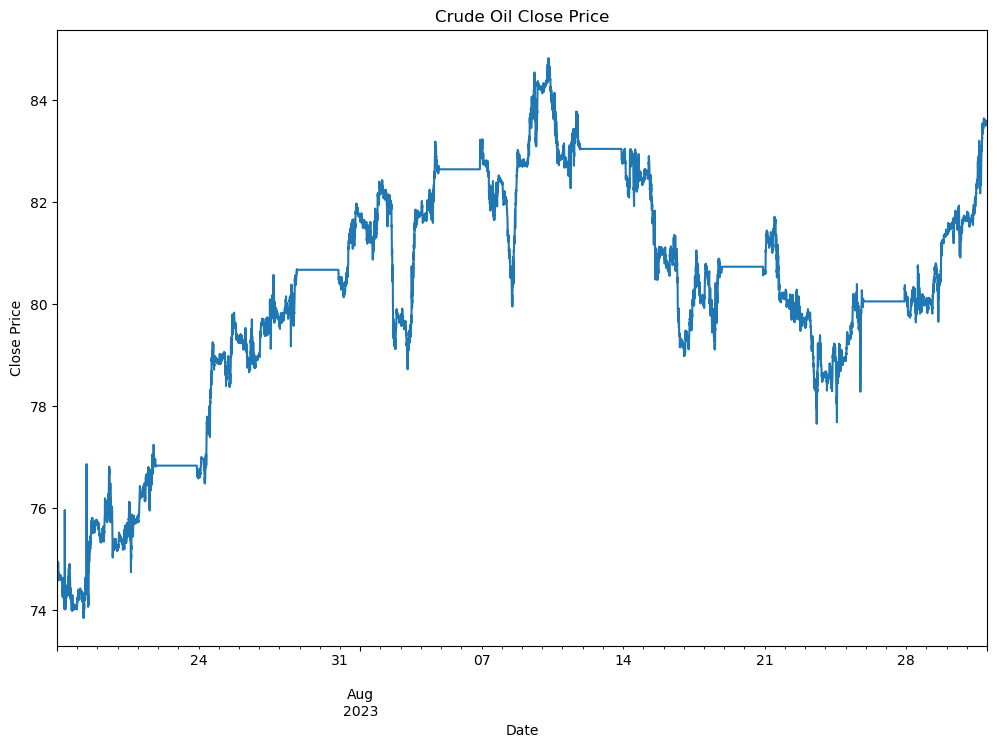

In [35]:
ax = df['Close'].plot(figsize=(12,8), title = 'Crude Oil Close Price',legend=False)
ax.set(xlabel='Date',ylabel='Close Price')

# 5. Autocorrelation and Partial Autocorrelation

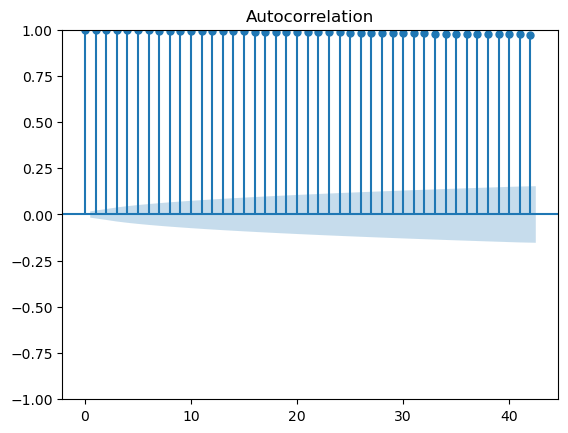

In [36]:
plot_acf(df['Close']);

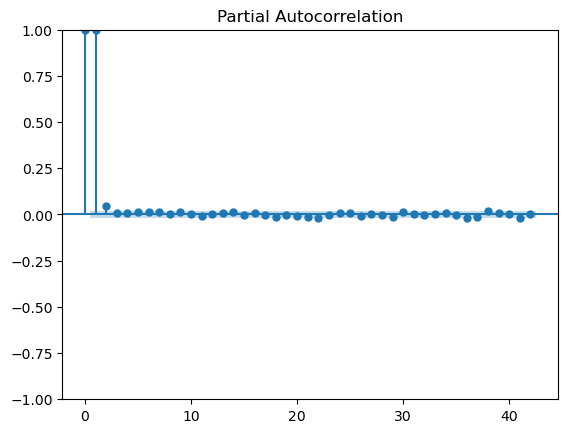

In [37]:
plot_pacf(df['Close']);

# 7. Data Stationarity

We check data stationarity using the Dickey-Fuller test

In [38]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [39]:
adf_test(df['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -2.109656
p-value                     0.240650
# lags used                40.000000
# observations          13206.000000
critical value (1%)        -3.430845
critical value (5%)        -2.861759
critical value (10%)       -2.566887
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


# 8. Forecasting on the Close Price

## 8.1 Select ARIMA Model Order

In [40]:
# Specify ARIMA order
auto_arima(df['Close']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                13247
Model:               SARIMAX(2, 1, 1)   Log Likelihood               15832.380
Date:                Mon, 22 Jan 2024   AIC                         -31656.760
Time:                        08:52:42   BIC                         -31626.794
Sample:                    07-17-2023   HQIC                        -31646.757
                         - 08-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7810      0.035     22.322      0.000       0.712       0.850
ar.L2          0.0365      0.005      7.275      0.000       0.027       0.046
ma.L1         -0.8512      0.035    -24.341      0.000      -0.920      -0.783
sigma2         0.0054   8.69e-06    616.878      0.000       0.005       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          17354655.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                       180.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
from statsmodels.tsa.statespace.tools import diff

df1 = diff(df['Close'],k_diff=1)

In [42]:
adf_test(df1)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.791171e+01
p-value                 2.927899e-30
# lags used             3.900000e+01
# observations          1.320600e+04
critical value (1%)    -3.430845e+00
critical value (5%)    -2.861759e+00
critical value (10%)   -2.566887e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


p = 1 is confirmed. Data now is stationary.

## 8.2 Train-Test Split

We are using the 5-min chart for trades. Each day has 24*60/5 = 288 Bars. We would like to make rolling predictions on the data we have, i.e., for each subinterval of the data, we predict the subsequent period. 

Data is split into training sets and test sets as follows: The first period of N observations is taken as the first training set, and the following n observations are taken to be the first test set. Then, the next training set is taken to be N+n, and the second test set is taken from N+n+1 to N+2n, i.e., we make a stride = n. We continue to roll to the end of the dataset.

In [43]:
# Define the lengths of the training set and test set
train_length = 288
test_span = 10

# Define empty lists to be filled by the training sets and test sets
training_sets = []

for step in range(1+int((len(df['Close'])-train_length)/test_span)):
    
    training_set = df.iloc[step*test_span:train_length+step*test_span]['Close']
    training_sets.append(training_set)

In [44]:
# Check how many training sets we have and verify the correctness thereof

print("Number of training sets: " + str(1+int((len(df['Close'])-train_length)/test_span)))
print("Number of training sets: " + str(len(training_sets)))

Number of training sets: 1296
Number of training sets: 1296


## 8.3 Training and Predictions 

In [45]:
# Define the ARIMA model, fit to data then make predictions. Predictions are made stepwise
start = train_length
end = train_length + test_span - 1

# Create a Dataframe of actual prices, with predictions to be filled in
df_actual_preds = pd.DataFrame(df['Close'])
df_actual_preds['Predictions'] = np.nan


# Loop over list of training sets. For each set, fit the model, then make predictions for the following 
# period on n observations, then append the results in the predictions list
for i in range(len(training_sets)-1):
    
    training_set = training_sets[i]
    
    model = SARIMAX(training_set,order=(2,1,1))
    arima_results = model.fit()
    
    
    prediction = np.round(arima_results.predict(start=start, end=end, dynamic=False, type='levels'),2)
    df_actual_preds.iloc[(i*test_span + train_length):(i*test_span + train_length+test_span),[1]] = prediction

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.01431D-01    |proj g|=  1.09550D-01

At iterate    5    f= -7.01476D-01    |proj g|=  1.51187D-03

At iterate   10    f= -7.03851D-01    |proj g|=  7.50567D-02

At iterate   15    f= -7.14014D-01    |proj g|=  1.78526D-01

At iterate   20    f= -7.28241D-01    |proj g|=  3.11585D-03

At iterate   25    f= -7.28275D-01    |proj g|=  3.01681D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     38      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.09059D-01    |proj g|=  2.69742D-03

At iterate   10    f= -7.09059D-01    |proj g|=  1.40216D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   7.221D-05  -7.091D-01
  F = -0.70905935589461666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.09298D-01    |proj g|=  1.07082D-01

At iterate    5    f= -7.09339D-01    |proj g|=  9.72461D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.11041D+00    |proj g|=  6.27052D-01

At iterate   10    f= -1.12147D+00    |proj g|=  7.01565D-02

At iterate   15    f= -1.12490D+00    |proj g|=  1.19557D+00

At iterate   20    f= -1.13559D+00    |proj g|=  3.20656D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     41      1     0     0   2.814D-03  -1.136D+00
  F =  -1.1356036334577337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f= -3.35374D-01    |proj g|=  1.82375D-01

At iterate    5    f= -3.36420D-01    |proj g|=  4.27546D-02

At iterate   10    f= -3.36439D-01    |proj g|=  1.35285D-02

At iterate   15    f= -3.36503D-01    |proj g|=  4.47353D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.691D-05  -3.365D-01
  F = -0.33651395999492018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.88408D-01    |proj g|=  7.35096D-02

At iterate   10    f= -2.89914D-01    |proj g|=  3.84308D-02

At iterate   15    f= -2.89936D-01    |proj g|=  5.38185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   1.849D-06  -2.899D-01
  F = -0.28993564384503123     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.85502D-01    |proj g|=  1.05676D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f= -2.84030D-01    |proj g|=  1.11867D-01

At iterate    5    f= -2.84286D-01    |proj g|=  6.70320D-02

At iterate   10    f= -2.84583D-01    |proj g|=  1.09698D-01

At iterate   15    f= -2.85368D-01    |proj g|=  3.61610D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   7.667D-07  -2.854D-01
  F = -0.28538067960717800     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.82097D-01    |proj g|=  1.17973D-01

At iterate    5    f= -2.82353D-01    |proj g|=  6.41101D-02

At iterate   10    f= -2.82573D-01    |proj g|=  9.05681D-02

At iterate   15    f= -2.83329D-01    |proj g|=  1.42039D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   8.776D-06  -2.833D-01
  F = -0.28333842836110418     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.84643D-01    |proj g|=  6.94194D-02

At iterate   10    f= -2.84928D-01    |proj g|=  1.05687D-01

At iterate   15    f= -2.85762D-01    |proj g|=  3.68694D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   3.197D-06  -2.858D-01
  F = -0.28577554709707886     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83770D-01    |proj g|=  1.20480D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.87656D-01    |proj g|=  1.41245D-01

At iterate   15    f= -2.88180D-01    |proj g|=  2.78092D-02

At iterate   20    f= -2.88199D-01    |proj g|=  1.99477D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   1.995D-06  -2.882D-01
  F = -0.28819867060466936     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.87743D-01    |proj g|=  1.15071D-01

At iter


At iterate   10    f= -1.34975D+00    |proj g|=  2.26810D-03


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.34975D+00    |proj g|=  9.41128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   1.353D-04  -1.350D+00
  F =  -1.3497463773091098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18356D+00    |proj g|=  4.93808D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.12725D+00    |proj g|=  5.75601D-02

At iterate   10    f= -1.12730D+00    |proj g|=  5.73254D-03

At iterate   15    f= -1.12730D+00    |proj g|=  8.18083D-03

At iterate   20    f= -1.12735D+00    |proj g|=  1.63789D-01

At iterate   25    f= -1.12767D+00    |proj g|=  4.70157D-03

At iterate   30    f= -1.12767D+00    |proj g|=  3.86955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     40      1     0     0   2.351D-05  -1.128D+00
  F =  -1.1276749715605492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12576D+00    |proj g|=  1.03598D-01

At iterate    5    f= -1.12580D+00    |proj g|=  9.22884D-02

At iterate   10    f= -1.12587D+00    |proj g|=  1.00582D-03

At iterate   15    f= -1.12590D+00    |proj g|=  4.86186D-03

At iterate   20    f= -1.12628D+00    |proj g|=  3.38366D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   7.609D-04  -1.126D+00
  F =  -1.1262835028783613     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.12830D+00    |proj g|=  5.24995D-04

At iterate   15    f= -1.12836D+00    |proj g|=  2.83149D-02

At iterate   20    f= -1.12878D+00    |proj g|=  9.43995D-03

At iterate   25    f= -1.12878D+00    |proj g|=  9.60270D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     55      1     0     0   1.992D-04  -1.129D+00
  F =  -1.1287830873208802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12466D+00    |proj g|=  9.27503D-02

At iterate    5    f= -1.12469D+00    |proj g|=  7.23962D-02

At iterate   10    f= -1.12474D+00    |proj g|=  1.22050D-03

At iterate   15    f= -1.12475D+00    |proj g|=  7.13306D-03

At iterate   20    f= -1.12492D+00    |proj g|=  2.19207D-02

At iterate   25    f= -1.12513D+00    |proj g|=  8.30878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     52      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     42      1     0     0   4.277D-04  -1.127D+00
  F =  -1.1272408223080426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12718D+00    |proj g|=  1.46243D-01

At iterate    5    f= -1.12723D+00    |proj g|=  6.06572D-02

At iterate   10    f= -1.12728D+00    |proj g|=  4.43709D-03

At iterate   15    f= -1.12729D+00    |proj g|=  8.10706D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.11871D+00    |proj g|=  3.61422D-02

At iterate   10    f= -1.11873D+00    |proj g|=  1.01286D-03

At iterate   15    f= -1.11874D+00    |proj g|=  1.98670D-03

At iterate   20    f= -1.11879D+00    |proj g|=  1.54921D-01

At iterate   25    f= -1.11891D+00    |proj g|=  5.63798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   4.390D-06  -1.119D+00
  F =  -1.1189109259123287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.10361D+00    |proj g|=  6.43602D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     50      1     0     0   5.783D-04  -1.104D+00
  F =  -1.1036139422866706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.35657D-01    |proj g|=  1.38699D+01

At iterate    5    f= -7.92282D-01    |proj g|=  5.49513D-01

At iterate   10    f= -1.04069D+00    |proj g|=  3.30691D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.10299D+00    |proj g|=  3.69237D-02

At iterate   25    f= -1.10362D+00    |proj g|=  3.71299D-01

At iterate   30    f= -1.10506D+00    |proj g|=  4.30930D-01

At iterate   35    f= -1.10669D+00    |proj g|=  5.63148D-02

At iterate   40    f= -1.10680D+00    |proj g|=  3.89810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     57      1     0     0   3.898D-05  -1.107D+00
  F =  -1.1067978623888044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.18951D+00    |proj g|=  1.95105D-02

At iterate   15    f= -1.18961D+00    |proj g|=  8.84912D-02

At iterate   20    f= -1.18975D+00    |proj g|=  9.70464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   7.268D-04  -1.190D+00
  F =  -1.1897466015149918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26168D+00    |proj g|=  6.32992D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.16407D+00    |proj g|=  1.65101D-01

At iterate   10    f= -1.16412D+00    |proj g|=  2.15472D-02

At iterate   15    f= -1.16414D+00    |proj g|=  5.67714D-03

At iterate   20    f= -1.16414D+00    |proj g|=  2.95960D-03

At iterate   25    f= -1.16417D+00    |proj g|=  5.73630D-02

At iterate   30    f= -1.16436D+00    |proj g|=  2.72962D-03

At iterate   35    f= -1.16436D+00    |proj g|=  6.82313D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     44      1     0     0   6.823D-05  -1.164D+00
  F =  -1.1643620837306803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.16683D+00    |proj g|=  2.34069D-03

At iterate   25    f= -1.16686D+00    |proj g|=  4.88371D-02

At iterate   30    f= -1.16705D+00    |proj g|=  6.86374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     52      1     0     0   1.801D-04  -1.167D+00
  F =  -1.1670560112574944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16639D+00    |proj g|=  1.46446D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.16907D+00    |proj g|=  1.27757D-02

At iterate   15    f= -1.16907D+00    |proj g|=  6.65944D-04

At iterate   20    f= -1.16908D+00    |proj g|=  6.57395D-03

At iterate   25    f= -1.16917D+00    |proj g|=  2.29320D-02

At iterate   30    f= -1.16927D+00    |proj g|=  4.62092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     43      1     0     0   4.617D-04  -1.169D+00
  F =  -1.1692689079885490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.15806D+00    |proj g|=  6.97659D-04

At iterate   20    f= -1.15807D+00    |proj g|=  5.81000D-02

At iterate   25    f= -1.15839D+00    |proj g|=  1.56205D-01

At iterate   30    f= -1.15852D+00    |proj g|=  4.33895D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     72      2     0     0   4.339D-05  -1.159D+00
  F =  -1.1585204771300941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15823D+00    |proj g|=  4.29358D-02

At iterate    5    f= -1.15954D+00    |proj g|=  5.05116D-02

At iterate   10    f= -1.15957D+00    |proj g|=  9.14448D-04

At iterate   15    f= -1.15957D+00    |proj g|=  1.33259D-02

At iterate   20    f= -1.15981D+00    |proj g|=  6.27666D-02

At iterate   25    f= -1.16008D+00    |proj g|=  1.47593D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.22460D+00    |proj g|=  4.55319D-02

At iterate   15    f= -1.22468D+00    |proj g|=  2.06540D-02

At iterate   20    f= -1.22468D+00    |proj g|=  2.03805D-02

At iterate   25    f= -1.22512D+00    |proj g|=  4.28158D-01

At iterate   30    f= -1.22567D+00    |proj g|=  2.72832D-02

At iterate   35    f= -1.22570D+00    |proj g|=  2.52538D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     46      1     0     0   2.256D-04  -1.226D+00
  F =  -1.2256990088721293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18652D+00    |proj g|=  4.70235D-01

At iterate    5    f= -1.18714D+00    |proj g|=  3.35964D-01

At iterate   10    f= -1.18958D+00    |proj g|=  1.72235D-02

At iterate   15    f= -1.18976D+00    |proj g|=  2.03837D-01

At iterate   20    f= -1.19044D+00    |proj g|=  2.41049D-02

At iterate   25    f= -1.19054D+00    |proj g|=  6.85687D-02

At iterate   30    f= -1.19326D+00    |proj g|=  2.05212D-02

At iterate   35    f= -1.19376D+00    |proj g|=  7.81443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -1.23757D+00    |proj g|=  1.63589D-02

At iterate   15    f= -1.23770D+00    |proj g|=  1.87897D-01

At iterate   20    f= -1.23815D+00    |proj g|=  8.51611D-03

At iterate   25    f= -1.23819D+00    |proj g|=  6.59695D-02

At iterate   30    f= -1.24199D+00    |proj g|=  7.93321D-01

At iterate   35    f= -1.24389D+00    |proj g|=  9.28830D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     82      2     0     0   1.681D-04  -1.244D+00
  F =  -1.2438860255700266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -1.29983D+00    |proj g|=  1.59244D-01

At iterate   10    f= -1.30094D+00    |proj g|=  7.99592D-02

At iterate   15    f= -1.30098D+00    |proj g|=  6.59549D-02

At iterate   20    f= -1.30119D+00    |proj g|=  2.12264D-02

At iterate   25    f= -1.30501D+00    |proj g|=  1.15600D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     48      1     0     0   7.404D-04  -1.305D+00
  F =  -1.3050445823169494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.31033D+00    |proj g|=  4.96593D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     43      1     0     0   5.096D-06  -1.310D+00
  F =  -1.3103405139303435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29518D+00    |proj g|=  2.74220D-01

At iterate    5    f= -1.29626D+00    |proj g|=  6.86191D-01

At iterate   10    f= -1.29927D+00    |proj g|=  3.08352D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.29955D+00    |proj g|=  3.66990D-01

At iterate   20    f= -1.30003D+00    |proj g|=  4.42276D-03

At iterate   25    f= -1.30015D+00    |proj g|=  1.39354D-01

At iterate   30    f= -1.30544D+00    |proj g|=  1.35686D+00

At iterate   35    f= -1.30758D+00    |proj g|=  7.77431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     46      1     0     0   9.341D-05  -1.308D+00
  F =  -1.3076576888173284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29962D+00    |proj g|=  4.14238D-01

At iterate    5    f= -1.30020D+00    |proj g|=  4.29711D-01

At iterate   10    f= -1.30380D+00    |proj g|=  2.46797D-02

At iterate   15    f= -1.30401D+00    |proj g|=  2.61086D-01

At iterate   20    f= -1.30471D+00    |proj g|=  2.16219D-02

At iterate   25    f= -1.30538D+00    |proj g|=  3.78982D-01

At iterate   30    f= -1.31229D+00    |proj g|=  1.51461D-02

At iterate   35    f= -1.31244D+00    |proj g|=  1.09723D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33887D+00    |proj g|=  4.97476D-02

At iterate    5    f= -1.34055D+00    |proj g|=  1.01760D-01

At iterate   10    f= -1.34060D+00    |proj g|=  8.63580D-02

At iterate   15    f= -1.34212D+00    |proj g|=  1.26157D+00

At iterate   20    f= -1.34508D+00    |proj g|=  3.93002D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   3.295D-05  -1.345D+00
  F =  -1.3450871660455230     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35257D+00    |proj g|=  1.84963D-01

At iterate    5    f= -1.35365D+00    |proj g|=  6.21141D-01

At iterate   10    f= -1.35447D+00    |proj g|=  2.34550D-02

At iterate   15    f= -1.35471D+00    |proj g|=  1.62494D-01

At iterate   20    f= -1.35481D+00    |proj g|=  1.05883D-01

At iterate   25    f= -1.35830D+00    |proj g|=  1.02075D+00

At iterate   30    f= -1.36007D+00    |proj g|=  3.22437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.44315D+00    |proj g|=  6.17654D-01

At iterate   25    f= -1.44616D+00    |proj g|=  4.39406D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   1.300D-03  -1.446D+00
  F =  -1.4462440978719968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.45417D+00    |proj g|=  1.76475D-01

At iterate    5    f= -1.45470D+00    |proj g|=  5.11982D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-4.769E-01  -gs= 8.542E-01 BFGS update SKIPPED

At iterate    5    f= -8.75914D-01    |proj g|=  8.51909D-01

At iterate   10    f= -1.38088D+00    |proj g|=  6.24640D-01

At iterate   15    f= -1.40100D+00    |proj g|=  9.36254D-01

At iterate   20    f= -1.54165D+00    |proj g|=  1.07056D-01

At iterate   25    f= -1.54811D+00    |proj g|=  3.32307D-03

At iterate   30    f= -1.54818D+00    |proj g|=  5.80411D-02

At iterate   35    f= -1.54993D+00    |proj g|=  6.11992D-01

At iterate   40    f= -1.55068D+00    |proj g|=  2.23065D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     75      1     1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.88584D+00    |proj g|=  1.60211D+00

At iterate   25    f= -1.89059D+00    |proj g|=  2.20401D-02

At iterate   30    f= -1.89060D+00    |proj g|=  2.12989D-01

At iterate   35    f= -1.89102D+00    |proj g|=  2.34989D-02

At iterate   40    f= -1.89130D+00    |proj g|=  9.18041D-02

At iterate   45    f= -1.89453D+00    |proj g|=  1.96728D-01

At iterate   50    f= -1.89616D+00    |proj g|=  1.06555D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     76      1     0     0   1.066D-01  -1.896D+00
  F =  -1.8961557629342023     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.08005D+00    |proj g|=  9.27383D-02

At iterate   10    f= -2.08204D+00    |proj g|=  2.43967D+00

At iterate   15    f= -2.08686D+00    |proj g|=  3.21628D-02

At iterate   20    f= -2.08709D+00    |proj g|=  3.79393D-01

At iterate   25    f= -2.08760D+00    |proj g|=  5.68538D-03

At iterate   30    f= -2.08765D+00    |proj g|=  8.53086D-02

At iterate   35    f= -2.08883D+00    |proj g|=  1.04149D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     46      1     0     0   8.984D-03  -2.089D+00
  F =  -2.0888789688678511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.39500D+00    |proj g|=  8.04043D+00
  ys=-1.055E-11  -gs= 7.448E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     70      2     1     0   1.446D-01  -3.396D+00
  F =  -3.3959778952661717     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possib

  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.38331D+00    |proj g|=  1.62132D-01

At iterate    5    f= -3.38336D+00    |proj g|=  1.52556D+00

At iterate   10    f= -3.38719D+00    |proj g|=  1.02292D+01

At iterate   15    f= -3.38950D+00    |proj g|=  4.79352D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   4.794D-03  -3.389D+00
  F =  -3.3894999387399078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     73      2     0     0   3.872D-02  -3.171D+00
  F =  -3.1706606227286631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66054D+00    |proj g|=  2.18616D+00

At iterate    5    f= -2.66095D+00    |proj g|=  8.23317D-01

At iterate   10    f= -2.66655D+00    |proj g|=  6.05662D+00

At iterate   15    f= -2.67021D+00    |proj g|=  1.36178D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -2.52289D+00    |proj g|=  4.67649D-01

At iterate   20    f= -2.52381D+00    |proj g|=  5.67038D-01

At iterate   25    f= -2.52388D+00    |proj g|=  2.23909D-01

At iterate   30    f= -2.52684D+00    |proj g|=  1.53907D+00

At iterate   35    f= -2.53024D+00    |proj g|=  1.78419D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     51      1     0     0   1.924D-02  -2.530D+00
  F =  -2.5302372099233668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.12861D+00    |proj g|=  6.31849D-01

At iterate    5    f= -2.12869D+00    |proj g|=  9.97394D-02

At iterate   10    f= -2.12882D+00    |proj g|=  2.15176D-01

At iterate   15    f= -2.12886D+00    |proj g|=  2.21804D-01

At iterate   20    f= -2.12943D+00    |proj g|=  6.92390D-01

At iterate   25    f= -2.13358D+00    |proj g|=  3.52316D-02

At iterate   30    f= -2.13424D+00    |proj g|=  1.88662D-01

At iterate   35    f= -2.13434D+00    |proj g|=  2.03504D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.72646D+00    |proj g|=  4.18342D-01

At iterate   30    f= -1.72883D+00    |proj g|=  5.60518D-02

At iterate   35    f= -1.73009D+00    |proj g|=  3.74611D-02

At iterate   40    f= -1.73010D+00    |proj g|=  2.51044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     58      1     0     0   2.510D-03  -1.730D+00
  F =  -1.7300996354269205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.64376D+00    |proj g|=  7.29688D-01

At iterate   10    f= -1.64421D+00    |proj g|=  3.36808D-02

At iterate   15    f= -1.64424D+00    |proj g|=  1.15657D-02

At iterate   20    f= -1.64429D+00    |proj g|=  1.50272D-01

At iterate   25    f= -1.64758D+00    |proj g|=  3.18834D-01

At iterate   30    f= -1.64796D+00    |proj g|=  4.85441D-02

At iterate   35    f= -1.64796D+00    |proj g|=  9.07076D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     63      1     0     0   9.071D-04  -1.648D+00
  F =  -1.6479622019156865     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.22203D+00    |proj g|=  4.44051D-02

At iterate   10    f= -1.22214D+00    |proj g|=  3.40466D-03

At iterate   15    f= -1.22215D+00    |proj g|=  3.64647D-02

At iterate   20    f= -1.22456D+00    |proj g|=  3.18093D-01

At iterate   25    f= -1.22538D+00    |proj g|=  1.77747D-01

At iterate   30    f= -1.22751D+00    |proj g|=  3.06950D-02

At iterate   35    f= -1.22852D+00    |proj g|=  2.25454D-02

At iterate   40    f= -1.22862D+00    |proj g|=  4.33667D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     55      1     0     0   5.197D-04  -1.229D+00
  F =  -1.22862061125

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18057D+00    |proj g|=  5.34726D-02

At iterate    5    f= -1.18244D+00    |proj g|=  6.34873D-02

At iterate   10    f= -1.18247D+00    |proj g|=  2.61252D-03

At iterate   15    f= -1.18249D+00    |proj g|=  5.23890D-02

At iterate   20    f= -1.18282D+00    |proj g|=  2.20720D-02

At iterate   25    f= -1.18286D+00    |proj g|=  1.16939D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.15104D+00    |proj g|=  1.08801D-01

At iterate   10    f= -1.15112D+00    |proj g|=  9.60220D-02

At iterate   15    f= -1.15114D+00    |proj g|=  3.69784D-03

At iterate   20    f= -1.15116D+00    |proj g|=  5.13850D-02

At iterate   25    f= -1.15131D+00    |proj g|=  3.55260D-02

At iterate   30    f= -1.15135D+00    |proj g|=  2.89577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     57      2     0     0   5.287D-05  -1.151D+00
  F =  -1.1513500420977931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.14970D+00    |proj g|=  8.17854D-02

At iterate   25    f= -1.14977D+00    |proj g|=  2.56722D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   6.906D-06  -1.150D+00
  F =  -1.1497667201711912     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15216D+00    |proj g|=  1.08386D-01

At iterate    5    f= -1.15315D+00    |proj g|=  7.94440D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     44      1     0     0   1.704D-04  -1.156D+00
  F =  -1.1557701146273258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15856D+00    |proj g|=  7.62030D-02

At iterate    5    f= -1.15981D+00    |proj g|=  1.08696D-02

At iterate   10    f= -1.15982D+00    |proj g|=  1.53241D-02

At iterate   15    f= -1.15991D+00    |proj g|=  1.47612D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.16380D+00    |proj g|=  8.31273D-04

At iterate   20    f= -1.16380D+00    |proj g|=  1.55131D-02

At iterate   25    f= -1.16388D+00    |proj g|=  1.20152D-01

At iterate   30    f= -1.16395D+00    |proj g|=  8.57695D-03

At iterate   35    f= -1.16395D+00    |proj g|=  8.42362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     51      1     0     0   1.134D-05  -1.164D+00
  F =  -1.1639524338656992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.15488D+00    |proj g|=  2.11011D-02

At iterate   10    f= -1.15490D+00    |proj g|=  9.44823D-04

At iterate   15    f= -1.15490D+00    |proj g|=  9.03596D-03

At iterate   20    f= -1.15504D+00    |proj g|=  8.16748D-02

At iterate   25    f= -1.15512D+00    |proj g|=  5.94712D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   1.857D-04  -1.155D+00
  F =  -1.1551213957305637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.23295D+00    |proj g|=  1.81629D-01

At iterate   10    f= -1.23353D+00    |proj g|=  7.57325D-03

At iterate   15    f= -1.23356D+00    |proj g|=  4.72720D-02

At iterate   20    f= -1.23357D+00    |proj g|=  3.35103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   3.351D-04  -1.234D+00
  F =  -1.2335684805416021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34051D+00    |proj g|=  6.97610D-01

At iterate    5    f= -1.34131D+00    |proj g|=  3.96334D-01

At iterate   10    f= -1.34554D+00    |proj g|=  3.09298D-02

At iterate   15    f= -1.34684D+00    |proj g|=  8.50300D-01

At iterate   20    f= -1.35118D+00    |proj g|=  2.62501D-02

At iterate   25    f= -1.35119D+00    |proj g|=  3.80956D-02

At iterate   30    f= -1.35160D+00    |proj g|=  5.25730D-01

At iterate   35    f= -1.35562D+00    |proj g|=  5.10349D-02

At iterate   40    f= -1.35571D+00    |proj g|=  1.87242D-02

At iterate   45    f= -1.35580D+00    |proj g|=  2.90581D-04

At iterate   50    f= -1.35581D+00    |proj g|=  3.46821D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.31461D+00    |proj g|=  5.58896D-01

At iterate   10    f= -1.31501D+00    |proj g|=  8.87394D-02

At iterate   15    f= -1.31524D+00    |proj g|=  1.40017D-02

At iterate   20    f= -1.31730D+00    |proj g|=  1.83618D-02

At iterate   25    f= -1.31731D+00    |proj g|=  7.85567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   4.285D-04  -1.317D+00
  F =  -1.3173061261259673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f= -1.31924D+00    |proj g|=  7.92765D-02

At iterate   10    f= -1.31930D+00    |proj g|=  2.81817D-02

At iterate   15    f= -1.31971D+00    |proj g|=  4.08559D-01

At iterate   20    f= -1.32115D+00    |proj g|=  3.95109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     39      1     0     0   1.157D-03  -1.321D+00
  F =  -1.3211517977738776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26901D+00    |proj g|=  3.47181D-02

At iterate    5    f= -1.26962D+00    |proj g|=  2.56313D-03

At iterate   10    f= -1.27108D+00    |proj g|=  1.07872D-02

At iterate   15    f= -1.27109D+00    |proj g|=  4.80210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     48      1     0     0   1.204D-03  -1.271D+00
  F =  -1.2710893910090115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     44      1     0     0   1.745D-04  -1.270D+00
  F =  -1.2698826624982671     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26876D+00    |proj g|=  1.22702D-01

At iterate    5    f= -1.26927D+00    |proj g|=  1.47685D-01

At iterate   10    f= -1.26931D+00    |proj g|=  5.40356D-02

At iterate   15    f= -1.26935D+00    |proj g|=  7.14968D-03

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f= -1.26740D+00    |proj g|=  4.51956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     47      1     0     0   1.512D-04  -1.267D+00
  F =  -1.2673974767672940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25896D+00    |proj g|=  3.51480D-02

At iterate    5    f= -1.25935D+00    |proj g|=  2.04943D-03

At iterate   10    f= -1.25981D+00    |proj g|=  1.60637D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.25905D+00    |proj g|=  3.72423D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     42      1     0     0   1.418D-03  -1.259D+00
  F =  -1.2591203764503256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25899D+00    |proj g|=  7.04469D-02

At iterate    5    f= -1.25934D+00    |proj g|=  2.16534D-02

At iterate   10    f= -1.25937D+00    |proj g|=  1.13849D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.27656D+00    |proj g|=  7.80174D-02

At iterate   35    f= -1.27699D+00    |proj g|=  1.24780D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     55      1     0     0   6.637D-05  -1.277D+00
  F =  -1.2769952302437213     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27827D+00    |proj g|=  3.55305D-01

At iterate    5    f= -1.27868D+00    |proj g|=  3.44190D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.27307D+00    |proj g|=  2.86882D-01

At iterate   10    f= -1.27325D+00    |proj g|=  3.04407D-02

At iterate   15    f= -1.27329D+00    |proj g|=  1.01725D-02

At iterate   20    f= -1.27381D+00    |proj g|=  1.67664D-01

At iterate   25    f= -1.27456D+00    |proj g|=  1.41231D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   5.171D-06  -1.275D+00
  F =  -1.2745656017541753     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.26194D+00    |proj g|=  8.18788D-03

At iterate   15    f= -1.26197D+00    |proj g|=  4.98977D-02

At iterate   20    f= -1.26320D+00    |proj g|=  2.88264D-01

At iterate   25    f= -1.26479D+00    |proj g|=  1.07474D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     39      1     0     0   1.932D-04  -1.265D+00
  F =  -1.2647864904296700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.24236D+00    |proj g|=  4.30179D-01

At iterate   30    f= -1.24349D+00    |proj g|=  2.26393D-01

At iterate   35    f= -1.24388D+00    |proj g|=  2.86706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     55      1     0     0   4.295D-03  -1.244D+00
  F =  -1.2438797770661867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21696D+00    |proj g|=  2.44543D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.22182D+00    |proj g|=  9.04941D-01

At iterate   30    f= -1.22358D+00    |proj g|=  2.46716D-02

At iterate   35    f= -1.22432D+00    |proj g|=  4.77785D-02

At iterate   40    f= -1.22450D+00    |proj g|=  3.20542D-03

At iterate   45    f= -1.22450D+00    |proj g|=  3.32944D-04

At iterate   50    f= -1.22450D+00    |proj g|=  1.13272D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     63      1     0     0   1.133D-03  -1.225D+00
  F =  -1.2245011402742105     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     50      1     0     0   1.147D-03  -1.238D+00
  F =  -1.2380019217442753     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23411D+00    |proj g|=  1.47487D-01

At iterate    5    f= -1.23976D+00    |proj g|=  4.02444D-03

At iterate   10    f= -1.23976D+00    |proj g|=  2.54882D-02

At iterate   15    f= -1.23976D+00    |proj g|=  1.31492D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f= -1.24898D+00    |proj g|=  1.14475D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     67      1     0     0   1.372D-04  -1.249D+00
  F =  -1.2489850000037757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23879D+00    |proj g|=  1.57304D-01

At iterate    5    f= -1.24401D+00    |proj g|=  1.07560D-02

At iterate   10    f= -1.24401D+00    |proj g|=  3.10377D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.24467D+00    |proj g|=  5.72187D-03

At iterate   20    f= -1.24553D+00    |proj g|=  1.13462D+00

At iterate   25    f= -1.25022D+00    |proj g|=  2.03525D-01

At iterate   30    f= -1.25073D+00    |proj g|=  4.78985D-02

At iterate   35    f= -1.25075D+00    |proj g|=  2.89551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     81      2     0     0   2.896D-04  -1.251D+00
  F =  -1.2507516144954112     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.23170D+00    |proj g|=  2.23191D-02

At iterate   15    f= -1.23170D+00    |proj g|=  1.29488D-02

At iterate   20    f= -1.23182D+00    |proj g|=  1.44300D-01

At iterate   25    f= -1.23582D+00    |proj g|=  9.79275D-02

At iterate   30    f= -1.23762D+00    |proj g|=  3.52023D-02

At iterate   35    f= -1.23768D+00    |proj g|=  7.24483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     53      1     0     0   2.238D-03  -1.238D+00
  F =  -1.2376800979318729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     61      1     0     0   7.102D-04  -1.250D+00
  F =  -1.2499807250282657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24146D+00    |proj g|=  8.62745D-02

At iterate    5    f= -1.24552D+00    |proj g|=  4.63012D-02

At iterate   10    f= -1.24553D+00    |proj g|=  9.46769D-03

At iterate   15    f= -1.24558D+00    |proj g|=  1.26870D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.23949D+00    |proj g|=  2.76710D-02

At iterate   15    f= -1.23954D+00    |proj g|=  3.28094D-02

At iterate   20    f= -1.23954D+00    |proj g|=  1.12748D-02

At iterate   25    f= -1.24004D+00    |proj g|=  3.94660D-01

At iterate   30    f= -1.24385D+00    |proj g|=  4.32151D-02

At iterate   35    f= -1.24437D+00    |proj g|=  9.29953D-03

At iterate   40    f= -1.24437D+00    |proj g|=  1.06720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     54      1     0     0   1.078D-03  -1.244D+00
  F =  -1.2443714397542334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.24152D+00    |proj g|=  7.60575D-03

At iterate   35    f= -1.24153D+00    |proj g|=  3.07885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     48      1     0     0   1.907D-04  -1.242D+00
  F =  -1.2415317139902884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25452D+00    |proj g|=  2.27075D-01

At iterate    5    f= -1.25459D+00    |proj g|=  6.13693D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.26838D+00    |proj g|=  3.05180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     43      1     0     0   3.052D-04  -1.268D+00
  F =  -1.2683776181767941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23245D+00    |proj g|=  2.76340D-01

At iterate    5    f= -1.23255D+00    |proj g|=  5.10104D-02

At iterate   10    f= -1.23261D+00    |proj g|=  4.08471D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.15464D+00    |proj g|=  1.86715D-02

At iterate   15    f= -1.15494D+00    |proj g|=  3.04365D-01

At iterate   20    f= -1.15610D+00    |proj g|=  3.75934D-02

At iterate   25    f= -1.15611D+00    |proj g|=  1.35203D-02

At iterate   30    f= -1.15699D+00    |proj g|=  4.10515D-01

At iterate   35    f= -1.15834D+00    |proj g|=  6.40960D-02

At iterate   40    f= -1.15842D+00    |proj g|=  1.42151D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     52      1     0     0   1.337D-05  -1.158D+00
  F =  -1.1584237570476541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     54      2     0     0   5.719D-04  -1.222D+00
  F =  -1.2216591980271245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19220D+00    |proj g|=  1.20034D-01

At iterate    5    f= -1.19222D+00    |proj g|=  2.04135D-02

At iterate   10    f= -1.19222D+00    |proj g|=  3.09419D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15200D+00    |proj g|=  1.81806D-01

At iterate    5    f= -1.15205D+00    |proj g|=  2.30755D-02

At iterate   10    f= -1.15206D+00    |proj g|=  5.40514D-04

At iterate   15    f= -1.15206D+00    |proj g|=  1.69076D-03

At iterate   20    f= -1.15210D+00    |proj g|=  1.94989D-02

At iterate   25    f= -1.15452D+00    |proj g|=  1.68584D-01

At iterate   30    f= -1.15699D+00    |proj g|=  2.77482D-02

At iterate   35    f= -1.15776D+00    |proj g|=  4.48610D-03
  ys=-2.828E-08  -gs= 1.541E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.15052D+00    |proj g|=  3.20411D-02

At iterate   10    f= -1.15054D+00    |proj g|=  5.52788D-04

At iterate   15    f= -1.15054D+00    |proj g|=  7.30548D-03

At iterate   20    f= -1.15102D+00    |proj g|=  3.04733D-01

At iterate   25    f= -1.15277D+00    |proj g|=  1.87514D-01

At iterate   30    f= -1.15668D+00    |proj g|=  5.38977D-02

At iterate   35    f= -1.15723D+00    |proj g|=  8.35444D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     49      1     0     0   1.150D-05  -1.157D+00
  F =  -1.1572267277267001     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.15447D+00    |proj g|=  5.77431D-01

At iterate   30    f= -1.15823D+00    |proj g|=  3.38729D-01

At iterate   35    f= -1.15973D+00    |proj g|=  3.49314D-01

At iterate   40    f= -1.16414D+00    |proj g|=  3.76498D-02

At iterate   45    f= -1.16432D+00    |proj g|=  1.98791D-02

At iterate   50    f= -1.16438D+00    |proj g|=  7.69188D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     64      1     0     0   7.692D-03  -1.164D+00
  F =  -1.1643808681752519     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.14643D+00    |proj g|=  2.17298D-03

At iterate   15    f= -1.14643D+00    |proj g|=  7.58367D-04

At iterate   20    f= -1.14643D+00    |proj g|=  1.48523D-02

At iterate   25    f= -1.14985D+00    |proj g|=  6.77945D-01

At iterate   30    f= -1.15264D+00    |proj g|=  4.88127D-02

At iterate   35    f= -1.15733D+00    |proj g|=  5.09293D-01

At iterate   40    f= -1.15949D+00    |proj g|=  1.78906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     54      1     0     0   6.780D-06  -1.159D+00
  F =  -1.1594921095222186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.15029D+00    |proj g|=  3.14799D-01

At iterate   20    f= -1.15179D+00    |proj g|=  6.71570D-01

At iterate   25    f= -1.15604D+00    |proj g|=  1.05026D-01

At iterate   30    f= -1.16229D+00    |proj g|=  7.47102D-02

At iterate   35    f= -1.16234D+00    |proj g|=  2.02623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     52      1     0     0   1.666D-04  -1.162D+00
  F =  -1.1623354244851882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17280D+00    |proj g|=  6.23122D-02

At iterate    5    f= -1.17281D+00    |proj g|=  4.01851D-02

At iterate   10    f= -1.17282D+00    |proj g|=  1.76776D-03

At iterate   15    f= -1.17282D+00    |proj g|=  4.86992D-04

At iterate   20    f= -1.17282D+00    |proj g|=  2.71513D-02

At iterate   25    f= -1.17362D+00    |proj g|=  4.59515D-01

At iterate   30    f= -1.17799D+00    |proj g|=  1.38807D-02

At iterate   35    f= -1.18082D+00    |proj g|=  3.72122D-01

At iterate   40    f= -1.18267D+00    |proj g|=  2.10814D-02

At iterate   45    f= -1.18267D+00    |proj g|=  4.93459D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.18037D+00    |proj g|=  7.33804D-03

At iterate   15    f= -1.18037D+00    |proj g|=  2.04920D-03

At iterate   20    f= -1.18037D+00    |proj g|=  2.10574D-02

At iterate   25    f= -1.18040D+00    |proj g|=  2.67777D-02

At iterate   30    f= -1.18041D+00    |proj g|=  1.20280D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     74      2     0     0   5.185D-05  -1.180D+00
  F =  -1.1804088871748086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.27107D+00    |proj g|=  2.87005D-02

At iterate   20    f= -1.27108D+00    |proj g|=  2.35145D-04

At iterate   25    f= -1.27112D+00    |proj g|=  1.59473D-01

At iterate   30    f= -1.27119D+00    |proj g|=  1.84471D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     37      1     0     0   7.787D-04  -1.271D+00
  F =  -1.2711925329049254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10161D+00    |proj g|=  3.81905D-02

At iterate    5    f= -1.10164D+00    |proj g|=  4.26550D-02

At iterate   10    f= -1.10165D+00    |proj g|=  8.01261D-03

At iterate   15    f= -1.10165D+00    |proj g|=  1.39433D-03

At iterate   20    f= -1.10165D+00    |proj g|=  4.18768D-02

At iterate   25    f= -1.10182D+00    |proj g|=  1.27655D-01

At iterate   30    f= -1.10188D+00    |proj g|=  8.36403D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     62      2     0     0   8.233D-05  -1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.13247D+00    |proj g|=  2.82598D-01

At iterate   10    f= -1.13390D+00    |proj g|=  5.55347D-02

At iterate   15    f= -1.13392D+00    |proj g|=  2.73838D-03

At iterate   20    f= -1.13394D+00    |proj g|=  4.41807D-02

At iterate   25    f= -1.13468D+00    |proj g|=  1.86291D-02

At iterate   30    f= -1.13476D+00    |proj g|=  5.86315D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     43      1     0     0   1.440D-03  -1.135D+00
  F =  -1.1347591533170025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.16891D+00    |proj g|=  1.06188D-03

At iterate   20    f= -1.16892D+00    |proj g|=  5.40332D-02

At iterate   25    f= -1.16934D+00    |proj g|=  5.12241D-02

At iterate   30    f= -1.16941D+00    |proj g|=  4.22881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     43      1     0     0   4.195D-05  -1.169D+00
  F =  -1.1694080680783767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.17199D+00    |proj g|=  1.71861D-03

At iterate   15    f= -1.17199D+00    |proj g|=  1.70260D-02

At iterate   20    f= -1.17211D+00    |proj g|=  2.67776D-01

At iterate   25    f= -1.17251D+00    |proj g|=  4.97585D-03

At iterate   30    f= -1.17252D+00    |proj g|=  2.76066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     50      1     0     0   1.852D-04  -1.173D+00
  F =  -1.1725166859619061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.19674D+00    |proj g|=  5.75051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   2.293D-04  -1.197D+00
  F =  -1.1967434195890680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19849D+00    |proj g|=  4.84905D-02

At iterate    5    f= -1.19967D+00    |proj g|=  3.32260D-03

At iterate   10    f= -1.19968D+00    |proj g|=  6.55786D-03

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.25905D+00    |proj g|=  3.18157D-02

At iterate   10    f= -1.25905D+00    |proj g|=  3.10767D-03

At iterate   15    f= -1.25906D+00    |proj g|=  4.85308D-02

At iterate   20    f= -1.25932D+00    |proj g|=  3.95446D-02

At iterate   25    f= -1.25954D+00    |proj g|=  6.20897D-02

At iterate   30    f= -1.25957D+00    |proj g|=  9.56418D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     44      1     0     0   2.655D-04  -1.260D+00
  F =  -1.2595714509546412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.30127D+00    |proj g|=  4.72077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   9.834D-04  -1.301D+00
  F =  -1.3012742286051511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35107D+00    |proj g|=  5.14556D+00

At iterate    5    f= -1.36768D+00    |proj g|=  1.61995D-01

At iterate   10    f= -1.36869D+00    |proj g|=  2.48764D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.84335D+00    |proj g|=  2.00350D-01

At iterate   30    f= -1.84337D+00    |proj g|=  2.73475D-02

At iterate   35    f= -1.84370D+00    |proj g|=  3.66320D-01

At iterate   40    f= -1.84388D+00    |proj g|=  1.19142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     48      1     0     0   1.191D-03  -1.844D+00
  F =  -1.8438754678549509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   10    f= -2.39955D+00    |proj g|=  2.40395D+00

At iterate   15    f= -2.40025D+00    |proj g|=  1.96095D-02

At iterate   20    f= -2.40048D+00    |proj g|=  6.76096D-02

At iterate   25    f= -2.40051D+00    |proj g|=  6.43622D-02

At iterate   30    f= -2.40370D+00    |proj g|=  4.28019D-01

At iterate   35    f= -2.42844D+00    |proj g|=  1.59497D+00

At iterate   40    f= -2.43019D+00    |proj g|=  2.63970D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     68      1     0     0   1.636D-03  -2.430D+00
  F =  -2.4302358999272493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30    108      2     0     0   4.563D-02  -2.968D+00
  F =  -2.9682526668989033     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.34827D+00    |proj g|=  2.63346D-01
  ys=-1.765E-11  -gs= 9.639E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -3.11702D+00    |proj g|=  1.75836D+01

At iterate   15    f= -3.13091D+00    |proj g|=  5.21256D-02

At iterate   20    f= -3.13170D+00    |proj g|=  1.04686D+00

At iterate   25    f= -3.13273D+00    |proj g|=  2.54336D-02

At iterate   30    f= -3.13300D+00    |proj g|=  1.27578D+00

At iterate   35    f= -3.14606D+00    |proj g|=  1.11824D+01

At iterate   40    f= -3.17322D+00    |proj g|=  5.93869D-01

At iterate   45    f= -3.17754D+00    |proj g|=  6.45091D-01

At iterate   50    f= -3.17814D+00    |proj g|=  6.94983D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     62   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.52627D+00    |proj g|=  1.89618D+00

At iterate   10    f= -2.52710D+00    |proj g|=  5.96756D-02

At iterate   15    f= -2.52751D+00    |proj g|=  1.03445D+00

At iterate   20    f= -2.52943D+00    |proj g|=  1.51068D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   5.032D-04  -2.529D+00
  F =  -2.5294395662453568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.34068D+00    |proj g|=  3.80571D-01

At iterate   10    f= -2.34148D+00    |proj g|=  5.04190D-01

At iterate   15    f= -2.34152D+00    |proj g|=  4.37503D-02

At iterate   20    f= -2.34162D+00    |proj g|=  8.12053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   6.218D-04  -2.342D+00
  F =  -2.3416167829880337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -2.00194D+00    |proj g|=  1.49235D-03

At iterate   20    f= -2.00197D+00    |proj g|=  1.01819D-02

At iterate   25    f= -2.00199D+00    |proj g|=  4.94336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     51      1     0     0   1.332D-04  -2.002D+00
  F =  -2.0019858375007127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87634D+00    |proj g|=  3.69088D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     38      1     1     0   5.666D-04  -1.814D+00
  F =  -1.8144173287824410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73673D+00    |proj g|=  3.31035D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.32361D+00    |proj g|=  2.46665D-01

At iterate   10    f= -1.32375D+00    |proj g|=  5.31695D-02

At iterate   15    f= -1.32407D+00    |proj g|=  2.26628D-01

At iterate   20    f= -1.32423D+00    |proj g|=  1.36013D-01

At iterate   25    f= -1.32590D+00    |proj g|=  6.10456D-01

At iterate   30    f= -1.32671D+00    |proj g|=  2.33595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     58      1     0     0   4.241D-05  -1.327D+00
  F =  -1.3267072068071577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.27105D+00    |proj g|=  6.12180D-02

At iterate   20    f= -1.27168D+00    |proj g|=  7.15206D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   9.461D-06  -1.272D+00
  F =  -1.2716883729691260     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24611D+00    |proj g|=  2.56223D-01

At iterate    5    f= -1.24628D+00    |proj g|=  3.97558D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.24129D+00    |proj g|=  4.16927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     41      1     0     0   3.307D-04  -1.241D+00
  F =  -1.2412874075875107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23379D+00    |proj g|=  2.46570D-01

At iterate    5    f= -1.23391D+00    |proj g|=  9.79864D-02

At iterate   10    f= -1.23394D+00    |proj g|=  2.09863D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.24003D+00    |proj g|=  6.57898D-02

At iterate   10    f= -1.24010D+00    |proj g|=  3.64021D-02

At iterate   15    f= -1.24015D+00    |proj g|=  1.97847D-02

At iterate   20    f= -1.24040D+00    |proj g|=  3.34426D-01

At iterate   25    f= -1.24073D+00    |proj g|=  5.64156D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     32      1     0     0   1.091D-05  -1.241D+00
  F =  -1.2407379984437859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f= -1.24893D+00    |proj g|=  8.15518D-02

At iterate   10    f= -1.24899D+00    |proj g|=  4.56302D-02

At iterate   15    f= -1.24929D+00    |proj g|=  3.33868D-01

At iterate   20    f= -1.24959D+00    |proj g|=  2.87616D-03

At iterate   25    f= -1.24959D+00    |proj g|=  4.00571D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   4.006D-05  -1.250D+00
  F =  -1.2495918272940685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.25257D+00    |proj g|=  7.22603D-02

At iterate   10    f= -1.25264D+00    |proj g|=  5.10052D-02

At iterate   15    f= -1.25277D+00    |proj g|=  1.17782D-01

At iterate   20    f= -1.25337D+00    |proj g|=  8.07769D-02

At iterate   25    f= -1.25340D+00    |proj g|=  6.49795D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     42      1     0     0   6.498D-05  -1.253D+00
  F =  -1.2533971756800097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.25690D+00    |proj g|=  6.01664D-03

At iterate   10    f= -1.25756D+00    |proj g|=  4.31766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     17      1     0     0   8.778D-06  -1.258D+00
  F =  -1.2575592761118743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26644D+00    |proj g|=  1.43238D-01

At iterate    5    f= -1.26647D+00    |proj g|=  6.83343D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    0    f= -1.26383D+00    |proj g|=  2.09284D-01

At iterate    5    f= -1.26392D+00    |proj g|=  1.21663D-01

At iterate   10    f= -1.26413D+00    |proj g|=  4.21850D-02

At iterate   15    f= -1.26424D+00    |proj g|=  1.76672D-01

At iterate   20    f= -1.26681D+00    |proj g|=  6.76031D-01

At iterate   25    f= -1.26813D+00    |proj g|=  4.37627D-02

At iterate   30    f= -1.26893D+00    |proj g|=  7.20992D-02

At iterate   35    f= -1.26896D+00    |proj g|=  1.09656D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     57      1     0     0   1.097D-03  -1.269D+00
  F =  -1.26896309771

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.51345D+00    |proj g|=  1.29046D-01

At iterate   10    f= -1.51375D+00    |proj g|=  5.80302D-03

At iterate   15    f= -1.51376D+00    |proj g|=  6.00520D-02

At iterate   20    f= -1.51377D+00    |proj g|=  2.99986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   3.494D-04  -1.514D+00
  F =  -1.5137737482151361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.42018D+00    |proj g|=  5.06195D-03

At iterate   10    f= -1.42019D+00    |proj g|=  7.66928D-02

At iterate   15    f= -1.42021D+00    |proj g|=  1.14215D-03

At iterate   20    f= -1.42021D+00    |proj g|=  2.86648D-02

At iterate   25    f= -1.42042D+00    |proj g|=  3.33463D-01

At iterate   30    f= -1.42086D+00    |proj g|=  1.41002D-02

At iterate   35    f= -1.42087D+00    |proj g|=  9.78878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     44      1     0     0   3.261D-05  -1.421D+00
  F =  -1.4208712292644126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     11      1     0     0   3.017D-04  -1.320D+00
  F =  -1.3202532219574197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22721D+00    |proj g|=  4.32681D-02

At iterate    5    f= -1.22769D+00    |proj g|=  4.37981D-02

At iterate   10    f= -1.22769D+00    |proj g|=  2.96561D-02

At iterate   15    f= -1.22772D+00    |proj g|=  5.37615D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19614D+00    |proj g|=  1.49969D-01

At iterate    5    f= -1.19617D+00    |proj g|=  3.24162D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     13      1     0     0   5.727D-04  -1.196D+00
  F =  -1.1961678815246093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     18      1     0     0   5.070D-04  -1.195D+00
  F =  -1.1950744369181523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16743D+00    |proj g|=  3.11708D-01

At iterate    5    f= -1.16810D+00    |proj g|=  3.97700D-01

At iterate   10    f= -1.16894D+00    |proj g|=  7.13902D-03

At iterate   15    f= -1.16897D+00    |proj g|=  2.67247D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.16972D+00    |proj g|=  5.07054D-02

At iterate   10    f= -1.16972D+00    |proj g|=  6.49818D-03

At iterate   15    f= -1.16973D+00    |proj g|=  6.41022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     36      1     0     0   6.410D-05  -1.170D+00
  F =  -1.1697253419547051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18229D+00    |proj g|=  5.38039D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.04358D+00    |proj g|=  8.78181D-03

At iterate   15    f= -1.04359D+00    |proj g|=  3.40398D-02

At iterate   20    f= -1.04361D+00    |proj g|=  2.21989D-02

At iterate   25    f= -1.04397D+00    |proj g|=  2.60449D-01

At iterate   30    f= -1.04674D+00    |proj g|=  1.41445D-01

At iterate   35    f= -1.04910D+00    |proj g|=  1.65118D-02

At iterate   40    f= -1.04923D+00    |proj g|=  8.58999D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     53      1     0     0   5.695D-04  -1.049D+00
  F =  -1.0492281910139509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -9.87657D-01    |proj g|=  1.53315D-01

At iterate   30    f= -9.89755D-01    |proj g|=  9.13622D-02

At iterate   35    f= -9.90246D-01    |proj g|=  6.48758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     47      1     0     0   1.009D-04  -9.902D-01
  F = -0.99024671408214615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.80135D-01    |proj g|=  2.08143D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     71      2     0     0   1.792D-04  -9.793D-01
  F = -0.97930129773637253     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.79425D-01    |proj g|=  1.29258D-01

At iterate    5    f= -9.80807D-01    |proj g|=  1.47683D-02

At iterate   10    f= -9.80915D-01    |proj g|=  1.65515D-02

At iterate   15    f= -9.80920D-01    |proj g|=  2.02989D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.04150D+00    |proj g|=  3.08652D-03

At iterate   10    f= -1.04460D+00    |proj g|=  6.15411D-02

At iterate   15    f= -1.05483D+00    |proj g|=  3.44161D-02

At iterate   20    f= -1.05500D+00    |proj g|=  9.92126D-02

At iterate   25    f= -1.05530D+00    |proj g|=  4.14779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   2.668D-04  -1.055D+00
  F =  -1.0552972685506483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.07412D+00    |proj g|=  5.62290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     56      1     0     0   5.623D-05  -1.074D+00
  F =  -1.0741218410085116     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06783D+00    |proj g|=  1.26978D-01

At iterate    5    f= -1.07013D+00    |proj g|=  1.61750D-02

At iterate   10    f= -1.07025D+00    |proj g|=  8.99470D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.06630D+00    |proj g|=  6.26605D-02

At iterate   10    f= -1.06647D+00    |proj g|=  1.07247D-01

At iterate   15    f= -1.06650D+00    |proj g|=  2.53188D-02

At iterate   20    f= -1.06684D+00    |proj g|=  1.63769D-01

At iterate   25    f= -1.07962D+00    |proj g|=  2.02083D-01

At iterate   30    f= -1.08130D+00    |proj g|=  2.24910D-01

At iterate   35    f= -1.08195D+00    |proj g|=  4.88881D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     44      1     0     0   5.773D-04  -1.082D+00
  F =  -1.0819530238241646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.06950D+00    |proj g|=  2.42508D-01

At iterate   25    f= -1.07017D+00    |proj g|=  7.44978D-02

At iterate   30    f= -1.07175D+00    |proj g|=  6.92489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     42      1     0     0   1.684D-04  -1.072D+00
  F =  -1.0717542498080563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05386D+00    |proj g|=  1.06166D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.05663D+00    |proj g|=  5.53780D-02

At iterate   10    f= -1.05672D+00    |proj g|=  2.62390D-02

At iterate   15    f= -1.05747D+00    |proj g|=  5.32012D-01

At iterate   20    f= -1.06933D+00    |proj g|=  1.47427D-01

At iterate   25    f= -1.07041D+00    |proj g|=  9.79575D-02

At iterate   30    f= -1.07069D+00    |proj g|=  1.97778D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     42      1     0     0   1.454D-05  -1.071D+00
  F =  -1.0706898741139430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.05582D+00    |proj g|=  1.45815D-01

At iterate   20    f= -1.06174D+00    |proj g|=  1.46095D+00

At iterate   25    f= -1.06636D+00    |proj g|=  1.14577D-01

At iterate   30    f= -1.06860D+00    |proj g|=  1.13889D-03

At iterate   35    f= -1.06864D+00    |proj g|=  1.36607D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     46      1     0     0   1.060D-04  -1.069D+00
  F =  -1.0686356735492342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03400D+00    |proj g|=  5.08551D-01

At iterate    5    f= -1.03500D+00    |proj g|=  3.68053D-01

At iterate   10    f= -1.03762D+00    |proj g|=  4.53455D-03

At iterate   15    f= -1.03764D+00    |proj g|=  4.74608D-02

At iterate   20    f= -1.03827D+00    |proj g|=  1.53783D-01

At iterate   25    f= -1.04519D+00    |proj g|=  3.37411D-01

At iterate   30    f= -1.04948D+00    |proj g|=  1.96327D-01

At iterate   35    f= -1.05075D+00    |proj g|=  1.50910D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -6.38881D-01    |proj g|=  1.28422D+00

At iterate   10    f= -8.87405D-01    |proj g|=  1.40044D-01

At iterate   15    f= -9.71577D-01    |proj g|=  1.49368D-01

At iterate   20    f= -9.72406D-01    |proj g|=  3.47616D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   2.137D-04  -9.724D-01
  F = -0.97240597401341966     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.00670D+00    |proj g|=  1.58202D-01

At iterate    5    f= -1.00675D+00    |proj g|=  2.26173D-02

At iterate   10    f= -1.00675D+00    |proj g|=  7.06922D-04

At iterate   15    f= -1.00676D+00    |proj g|=  7.72834D-03

At iterate   20    f= -1.00676D+00    |proj g|=  6.29554D-03

At iterate   25    f= -1.00678D+00    |proj g|=  8.34044D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.00482D+00    |proj g|=  9.40954D-03

At iterate   10    f= -1.00483D+00    |proj g|=  2.43397D-02

At iterate   15    f= -1.00485D+00    |proj g|=  4.02830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   6.969D-05  -1.005D+00
  F =  -1.0048569617412459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.00486D+00    |proj g|=  1.59299D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.00722D+00    |proj g|=  2.10052D-02

At iterate   20    f= -1.00722D+00    |proj g|=  2.26883D-03

At iterate   25    f= -1.00722D+00    |proj g|=  9.57862D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     40      1     0     0   9.579D-05  -1.007D+00
  F =  -1.0072224263154899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.00732D+00    |proj g|=  7.44215D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01083D+00    |proj g|=  1.41957D-01

At iterate    5    f= -1.01087D+00    |proj g|=  3.26236D-02

At iterate   10    f= -1.01089D+00    |proj g|=  6.98505D-04

At iterate   15    f= -1.01089D+00    |proj g|=  9.88872D-03

At iterate   20    f= -1.01092D+00    |proj g|=  9.13354D-03

At iterate   25    f= -1.01095D+00    |proj g|=  2.09475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     36      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.01384D+00    |proj g|=  6.43871D-03

At iterate   25    f= -1.01385D+00    |proj g|=  9.39166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     37      1     0     0   1.341D-04  -1.014D+00
  F =  -1.0138514969691412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02552D+00    |proj g|=  9.40008D-02

At iterate    5    f= -1.02554D+00    |proj g|=  3.49815D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.03545D+00    |proj g|=  1.31334D-01

At iterate   25    f= -1.03562D+00    |proj g|=  4.51348D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   4.513D-06  -1.036D+00
  F =  -1.0356239643371543     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03335D+00    |proj g|=  9.60642D-02

At iterate    5    f= -1.03358D+00    |proj g|=  2.38254D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.27419D+00    |proj g|=  2.26480D-03

At iterate   15    f= -1.27420D+00    |proj g|=  1.32700D-02

At iterate   20    f= -1.27454D+00    |proj g|=  1.78406D-01

At iterate   25    f= -1.27493D+00    |proj g|=  3.81131D-02

At iterate   30    f= -1.27496D+00    |proj g|=  1.91638D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     41      1     0     0   1.799D-03  -1.275D+00
  F =  -1.2749556782852389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.33620D+00    |proj g|=  1.44223D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     46      1     0     0   2.523D-04  -1.336D+00
  F =  -1.3362005291986785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33195D+00    |proj g|=  4.61916D-02

At iterate    5    f= -1.33373D+00    |proj g|=  8.73436D-02

At iterate   10    f= -1.33376D+00    |proj g|=  7.14801D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   4.589D-05  -1.339D+00
  F =  -1.3394180740494273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33079D+00    |proj g|=  5.88218D-02

At iterate    5    f= -1.33383D+00    |proj g|=  6.01597D-02

At iterate   10    f= -1.33403D+00    |proj g|=  1.19402D-02

At iterate   15    f= -1.33462D+00    |proj g|=  1.66020D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33717D+00    |proj g|=  6.03934D-02

At iterate    5    f= -1.34061D+00    |proj g|=  3.12399D-02

At iterate   10    f= -1.34088D+00    |proj g|=  3.02372D-03

At iterate   15    f= -1.34090D+00    |proj g|=  3.37607D-02

At iterate   20    f= -1.34199D+00    |proj g|=  6.25146D-02

At iterate   25    f= -1.34220D+00    |proj g|=  2.36073D-03

At iterate   30    f= -1.34220D+00    |proj g|=  3.73329D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.35935D+00    |proj g|=  1.15890D-01

At iterate   30    f= -1.35950D+00    |proj g|=  2.76274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     46      1     0     0   2.763D-04  -1.360D+00
  F =  -1.3595048917921604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.36893D+00    |proj g|=  9.71620D-02

At iterate    5    f= -1.37300D+00    |proj g|=  8.12641D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37715D+00    |proj g|=  8.11139D-02

At iterate    5    f= -1.38146D+00    |proj g|=  1.12508D-01

At iterate   10    f= -1.38174D+00    |proj g|=  3.48372D-02

At iterate   15    f= -1.38219D+00    |proj g|=  2.83318D-01

At iterate   20    f= -1.38351D+00    |proj g|=  5.17781D-02

At iterate   25    f= -1.38355D+00    |proj g|=  2.03298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.44102D+00    |proj g|=  2.00409D-02

At iterate   10    f= -1.44128D+00    |proj g|=  3.28022D-03

At iterate   15    f= -1.44129D+00    |proj g|=  4.51369D-02

At iterate   20    f= -1.44220D+00    |proj g|=  6.63095D-03

At iterate   25    f= -1.44224D+00    |proj g|=  5.11592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   6.914D-04  -1.442D+00
  F =  -1.4422399717805385     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64568D+00    |proj g|=  1.17203D+00

At iterate    5    f= -1.64660D+00    |proj g|=  3.18826D-01

At iterate   10    f= -1.64668D+00    |proj g|=  8.33667D-04

At iterate   15    f= -1.64670D+00    |proj g|=  7.36327D-02

At iterate   20    f= -1.64671D+00    |proj g|=  4.36300D-03

At iterate   25    f= -1.64671D+00    |proj g|=  4.17442D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     41      1     0     0   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.88826D+00    |proj g|=  1.88633D-01

At iterate   15    f= -1.88828D+00    |proj g|=  6.24399D-02

At iterate   20    f= -1.88837D+00    |proj g|=  1.50401D-02

At iterate   25    f= -1.88840D+00    |proj g|=  5.89084D-02

At iterate   30    f= -1.88888D+00    |proj g|=  5.60659D-02

At iterate   35    f= -1.88891D+00    |proj g|=  8.37548D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     43      1     0     0   8.375D-04  -1.889D+00
  F =  -1.8889139616563813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.33755D+00    |proj g|=  6.08872D-02

At iterate   35    f= -2.34465D+00    |proj g|=  3.97544D-01

At iterate   40    f= -2.35022D+00    |proj g|=  2.42026D-01

At iterate   45    f= -2.35068D+00    |proj g|=  4.01026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     99      2     0     0   5.976D-03  -2.351D+00
  F =  -2.3506822350920675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     85      2     0     0   9.737D-04  -2.814D+00
  F =  -2.8137033943134306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.39996D+00    |proj g|=  9.01708D+00

At iterate    5    f= -3.40117D+00    |proj g|=  8.31532D-01

At iterate   10    f= -3.40593D+00    |proj g|=  1.42429D+01

At iterate   15    f= -3.40916D+00    |proj g|=  6.09051D-02

At iter

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.05747D+00    |proj g|=  4.59405D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.01587D+00    |proj g|=  4.24756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     40      1     0     0   2.726D-04  -2.016D+00
  F =  -2.0158699330593652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.98084D+00    |proj g|=  3.28771D-01

At iterate    5    f= -1.98087D+00    |proj g|=  1.10402D-01

At iterate   10    f= -1.98106D+00    |proj g|=  1.90956D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.74085D+00    |proj g|=  1.39566D-03

At iterate   25    f= -1.74088D+00    |proj g|=  1.64317D-02

At iterate   30    f= -1.74159D+00    |proj g|=  2.24729D-01

At iterate   35    f= -1.74177D+00    |proj g|=  7.51002D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     65      1     0     0   6.963D-04  -1.742D+00
  F =  -1.7417695411653276     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     97      2     0     0   1.795D-03  -1.720D+00
  F =  -1.7201755374185623     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70308D+00    |proj g|=  6.79582D-01

At iterate    5    f= -1.70354D+00    |proj g|=  4.28600D-01

At iterate   10    f= -1.70398D+00    |proj g|=  9.53032D-02

At iterate   15    f= -1.70478D+00    |proj g|=  8.85348D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.65000D+00    |proj g|=  5.78225D-02

At iterate   15    f= -1.65122D+00    |proj g|=  2.30142D-03

At iterate   20    f= -1.65147D+00    |proj g|=  6.69393D-02

At iterate   25    f= -1.65292D+00    |proj g|=  6.90596D-02

At iterate   30    f= -1.65306D+00    |proj g|=  4.31995D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     45      1     0     0   4.320D-04  -1.653D+00
  F =  -1.6530581276964869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.49343D+00    |proj g|=  4.08402D-01

At iterate   10    f= -1.49358D+00    |proj g|=  1.07664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   9.215D-05  -1.494D+00
  F =  -1.4935828447833019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48533D+00    |proj g|=  2.15313D-01

At iterate    5    f= -1.48548D+00    |proj g|=  2.65945D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.36591D+00    |proj g|=  8.30216D-04

At iterate   25    f= -1.36592D+00    |proj g|=  1.00613D-02

At iterate   30    f= -1.36632D+00    |proj g|=  2.50848D-03

At iterate   35    f= -1.36739D+00    |proj g|=  1.19099D-02

At iterate   40    f= -1.36743D+00    |proj g|=  3.41624D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     61      1     0     0   3.416D-04  -1.367D+00
  F =  -1.3674282711292907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.23380D+00    |proj g|=  3.08826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   3.563D-04  -1.234D+00
  F =  -1.2337977678402348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20374D+00    |proj g|=  7.49661D-02

At iterate    5    f= -1.20601D+00    |proj g|=  3.87990D-02

At iterate   10    f= -1.20614D+00    |proj g|=  1.11099D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17512D+00    |proj g|=  8.09673D-02

At iterate    5    f= -1.17716D+00    |proj g|=  1.66671D-02

At iterate   10    f= -1.17726D+00    |proj g|=  1.73281D-01

At iterate   15    f= -1.17735D+00    |proj g|=  1.39295D-03

At iterate   20    f= -1.17744D+00    |proj g|=  4.84163D-02

At iterate   25    f= -1.17914D+00    |proj g|=  1.31166D-01

At iterate   30    f= -1.18452D+00    |proj g|=  1.73885D-02

At iterate   35    f= -1.18471D+00    |proj g|=  1.55438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27568D+00    |proj g|=  2.65643D-01

At iterate    5    f= -1.27581D+00    |proj g|=  1.09355D-01

At iterate   10    f= -1.27585D+00    |proj g|=  3.30188D-03

At iterate   15    f= -1.27586D+00    |proj g|=  3.99547D-02

At iterate   20    f= -1.27591D+00    |proj g|=  9.78840D-02

At iterate   25    f= -1.27635D+00    |proj g|=  9.18060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     40      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.27767D+00    |proj g|=  1.75777D-01

At iterate   15    f= -1.27783D+00    |proj g|=  2.07562D-03

At iterate   20    f= -1.27798D+00    |proj g|=  1.83440D-01

At iterate   25    f= -1.28152D+00    |proj g|=  9.71737D-02

At iterate   30    f= -1.28199D+00    |proj g|=  3.04461D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     48      1     0     0   3.045D-02  -1.282D+00
  F =  -1.2819868950231859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.34159D+00    |proj g|=  1.54299D-03

At iterate   15    f= -1.34159D+00    |proj g|=  1.43030D-02

At iterate   20    f= -1.34467D+00    |proj g|=  9.65507D-02

At iterate   25    f= -1.34471D+00    |proj g|=  1.22647D-02

At iterate   30    f= -1.34472D+00    |proj g|=  7.18256D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     41      1     0     0   7.183D-04  -1.345D+00
  F =  -1.3447239015886032     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.31044D+00    |proj g|=  2.69574D-01

At iterate    5    f= -1.31444D+00    |proj g|=  8.15939D-01

At iterate   10    f= -1.31543D+00    |proj g|=  7.88234D-02

At iterate   15    f= -1.31548D+00    |proj g|=  1.81403D-03

At iterate   20    f= -1.31548D+00    |proj g|=  3.65545D-02

At iterate   25    f= -1.31606D+00    |proj g|=  6.29161D-01

At iterate   30    f= -1.31678D+00    |proj g|=  7.23829D-03

At iterate   35    f= -1.31686D+00    |proj g|=  6.72656D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.32615D+00    |proj g|=  1.82871D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     42      1     0     0   1.242D-03  -1.326D+00
  F =  -1.3261581108512845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.31344D+00    |proj g|=  7.93190D-02

At iterate    5    f= -1.31365D+00    |proj g|=  1.63472D-02

At iterate   10    f= -1.31365D+00    |proj g|=  4.32503D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24251D+00    |proj g|=  3.90799D-01

At iterate    5    f= -1.24318D+00    |proj g|=  4.45062D-01

At iterate   10    f= -1.24587D+00    |proj g|=  8.85893D-03

At iterate   15    f= -1.24591D+00    |proj g|=  6.41234D-02

At iterate   20    f= -1.24603D+00    |proj g|=  3.18848D-02

At iterate   25    f= -1.24944D+00    |proj g|=  2.02936D-01

At iterate   30    f= -1.24992D+00    |proj g|=  7.19507D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.09801D+00    |proj g|=  6.46012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     55      1     0     0   2.638D-05  -1.098D+00
  F =  -1.0980318695489908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09716D+00    |proj g|=  8.91571D-01

At iterate    5    f= -1.09835D+00    |proj g|=  8.06436D-02

At iterate   10    f= -1.09872D+00    |proj g|=  2.81195D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.08867D+00    |proj g|=  1.28929D-01

At iterate   30    f= -1.08993D+00    |proj g|=  3.44373D-02

At iterate   35    f= -1.09050D+00    |proj g|=  2.33664D-01

At iterate   40    f= -1.09118D+00    |proj g|=  1.43792D-02

At iterate   45    f= -1.09118D+00    |proj g|=  1.97467D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     52      1     0     0   1.975D-04  -1.091D+00
  F =  -1.0911847178974392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.09921D+00    |proj g|=  1.17000D-03

At iterate   15    f= -1.09925D+00    |proj g|=  1.39996D-02

At iterate   20    f= -1.09931D+00    |proj g|=  3.97975D-04

At iterate   25    f= -1.09932D+00    |proj g|=  1.75223D-02

At iterate   30    f= -1.09967D+00    |proj g|=  2.24132D-01

At iterate   35    f= -1.09989D+00    |proj g|=  3.44008D-03

At iterate   40    f= -1.09991D+00    |proj g|=  7.21037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     52      1     0     0   1.379D-03  -1.100D+00
  F =  -1.0999064809215284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.08957D+00    |proj g|=  1.48364D-01

At iterate   10    f= -1.08963D+00    |proj g|=  1.67903D-02

At iterate   15    f= -1.08969D+00    |proj g|=  5.49056D-02

At iterate   20    f= -1.08971D+00    |proj g|=  1.97524D-02

At iterate   25    f= -1.09018D+00    |proj g|=  1.65144D-01

At iterate   30    f= -1.09478D+00    |proj g|=  1.29836D-01

At iterate   35    f= -1.09531D+00    |proj g|=  8.97609D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     46      1     0     0   2.734D-06  -1.095D+00
  F =  -1.0953115883891105     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.08119D+00    |proj g|=  4.50264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     57      1     0     0   4.503D-04  -1.081D+00
  F =  -1.0811907517292783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07255D+00    |proj g|=  1.61207D-01

At iterate    5    f= -1.07260D+00    |proj g|=  2.08100D-02

At iterate   10    f= -1.07260D+00    |proj g|=  5.95426D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   2.713D-04  -1.075D+00
  F =  -1.0750380197652794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07773D+00    |proj g|=  1.47691D-01

At iterate    5    f= -1.07777D+00    |proj g|=  5.29530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09986D+00    |proj g|=  6.88994D-02

At iterate    5    f= -1.09987D+00    |proj g|=  3.96167D-02

At iterate   10    f= -1.09989D+00    |proj g|=  1.03499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   9.417D-05  -1.100D+00
  F =  -1.0998855411021711     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f= -1.08253D+00    |proj g|=  1.02856D-01

At iterate   10    f= -1.08263D+00    |proj g|=  7.85547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   2.658D-04  -1.083D+00
  F =  -1.0826291447722294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08165D+00    |proj g|=  2.47526D-02

At iterate    5    f= -1.08180D+00    |proj g|=  1.52128D-03

        

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.11103D+00    |proj g|=  6.88170D-02

At iterate   10    f= -1.11115D+00    |proj g|=  2.25123D-03

At iterate   15    f= -1.11116D+00    |proj g|=  1.55539D-02

At iterate   20    f= -1.11117D+00    |proj g|=  2.72030D-02

At iterate   25    f= -1.11143D+00    |proj g|=  5.71835D-02

At iterate   30    f= -1.11145D+00    |proj g|=  4.60630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     42      1     0     0   4.580D-05  -1.111D+00
  F =  -1.1114544933753696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.19126D+00    |proj g|=  1.17022D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     33      1     0     0   1.129D-06  -1.191D+00
  F =  -1.1912614367770731     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12157D+00    |proj g|=  7.18402D-01

At iterate    5    f= -1.12379D+00    |proj g|=  6.38965D-01

At iterate   10    f= -1.12889D+00    |proj g|=  4.42037D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.07686D+00    |proj g|=  6.81985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   3.983D-06  -1.077D+00
  F =  -1.0768614403505294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07290D+00    |proj g|=  2.03175D-01

At iterate    5    f= -1.07299D+00    |proj g|=  6.87934D-02

At iterate   10    f= -1.07302D+00    |proj g|=  4.02320D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.05507D+00    |proj g|=  8.95613D-04

At iterate   20    f= -1.05507D+00    |proj g|=  1.65534D-02

At iterate   25    f= -1.05507D+00    |proj g|=  7.74980D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   7.750D-05  -1.055D+00
  F =  -1.0550746238468629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06098D+00    |proj g|=  1.75645D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.06590D+00    |proj g|=  1.30647D-03

At iterate   15    f= -1.06590D+00    |proj g|=  1.00696D-02

At iterate   20    f= -1.06590D+00    |proj g|=  1.20477D-02

At iterate   25    f= -1.06591D+00    |proj g|=  4.43310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   4.407D-05  -1.066D+00
  F =  -1.0659099116064876     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     54      2     0     0   3.041D-05  -1.067D+00
  F =  -1.0673444843983968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06685D+00    |proj g|=  1.72965D-01

At iterate    5    f= -1.06690D+00    |proj g|=  1.77911D-02

At iterate   10    f= -1.06691D+00    |proj g|=  8.84477D-04

At iterate   15    f= -1.06691D+00    |proj g|=  7.24772D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04912D+00    |proj g|=  2.20747D-01

At iterate    5    f= -1.04927D+00    |proj g|=  1.22530D-01

At iterate   10    f= -1.04938D+00    |proj g|=  1.72136D-03

At iterate   15    f= -1.04939D+00    |proj g|=  3.45792D-02

At iterate   20    f= -1.04966D+00    |proj g|=  1.00549D-01

At iterate   25    f= -1.04977D+00    |proj g|=  4.21482D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     36      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.12206D+00    |proj g|=  7.27383D-03

At iterate   15    f= -1.12206D+00    |proj g|=  1.24832D-03

At iterate   20    f= -1.12206D+00    |proj g|=  1.61890D-02

At iterate   25    f= -1.12225D+00    |proj g|=  1.66473D-01

At iterate   30    f= -1.12288D+00    |proj g|=  2.06737D-02

At iterate   35    f= -1.12292D+00    |proj g|=  4.50220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     40      1     0     0   4.502D-04  -1.123D+00
  F =  -1.1229158303995161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.20673D+00    |proj g|=  3.23435D-03

At iterate   25    f= -1.20692D+00    |proj g|=  3.08825D-02

At iterate   30    f= -1.20695D+00    |proj g|=  1.17775D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     39      1     0     0   1.027D-03  -1.207D+00
  F =  -1.2069556841399605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19393D+00    |proj g|=  9.26866D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17657D+00    |proj g|=  1.56827D-01

At iterate    5    f= -1.17660D+00    |proj g|=  3.60661D-03

At iterate   10    f= -1.17683D+00    |proj g|=  6.96780D-02

At iterate   15    f= -1.17993D+00    |proj g|=  6.97426D-02

At iterate   20    f= -1.18317D+00    |proj g|=  8.21765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     37      1     0     0   2.224D-04  -1.183D+00
  F =  -1.1832335860541052     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     60      1     0     0   7.338D-05  -1.171D+00
  F =  -1.1708287438250986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16336D+00    |proj g|=  1.86953D-01

At iterate    5    f= -1.16341D+00    |proj g|=  1.48945D-02

At iterate   10    f= -1.16342D+00    |proj g|=  1.83224D-02

At iterate   15    f= -1.16345D+00    |proj g|=  7.71993D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.16347D+00    |proj g|=  1.45251D-02

At iterate   10    f= -1.16347D+00    |proj g|=  1.39772D-02

At iterate   15    f= -1.16350D+00    |proj g|=  9.04471D-02

At iterate   20    f= -1.16416D+00    |proj g|=  6.93937D-01

At iterate   25    f= -1.16677D+00    |proj g|=  9.90515D-01

At iterate   30    f= -1.16968D+00    |proj g|=  6.68848D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     41      1     0     0   7.735D-06  -1.170D+00
  F =  -1.1697119472104232     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.13092D+00    |proj g|=  2.75527D-02

At iterate   20    f= -1.13093D+00    |proj g|=  5.24535D-02

At iterate   25    f= -1.13227D+00    |proj g|=  8.39635D-01

At iterate   30    f= -1.13500D+00    |proj g|=  6.01850D-03

At iterate   35    f= -1.13500D+00    |proj g|=  5.91217D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     59      1     0     0   5.912D-04  -1.135D+00
  F =  -1.1349958000564717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     64      2     0     0   4.000D-04  -1.139D+00
  F =  -1.1388141219598751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14781D+00    |proj g|=  1.12715D-01

At iterate    5    f= -1.14783D+00    |proj g|=  1.93798D-02

At iterate   10    f= -1.14783D+00    |proj g|=  3.25409D-03

At iterate   15    f= -1.14783D+00    |proj g|=  2.17554D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12669D+00    |proj g|=  4.89164D-02

At iterate    5    f= -1.12670D+00    |proj g|=  4.17104D-02

At iterate   10    f= -1.12671D+00    |proj g|=  1.66593D-02

At iterate   15    f= -1.12674D+00    |proj g|=  4.81128D-02

At iterate   20    f= -1.12943D+00    |proj g|=  1.88857D-01

At iterate   25    f= -1.12981D+00    |proj g|=  9.23711D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06259D+00    |proj g|=  1.04438D-01

At iterate    5    f= -1.06473D+00    |proj g|=  4.83158D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     14      1     0     0   7.145D-04  -1.065D+00
  F =  -1.0647398941703010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07954D+00    |proj g|=  5.10551D-02

At iterate    5    f= -1.07972D+00    |proj g|=  1.05700D-02

At iterate   10    f= -1.07975D+00    |proj g|=  9.30347D-02

At iterate   15    f= -1.07981D+00    |proj g|=  2.42893D-02

At iterate   20    f= -1.08174D+00    |proj g|=  3.88448D-01

At iterate   25    f= -1.08370D+00    |proj g|=  2.27904D-03

At iterate   30    f= -1.08370D+00    |proj g|=  1.15094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.14765D+00    |proj g|=  6.80392D-01

At iterate   25    f= -1.14913D+00    |proj g|=  1.70568D-01

At iterate   30    f= -1.15497D+00    |proj g|=  2.22904D-03

At iterate   35    f= -1.15499D+00    |proj g|=  2.56511D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     48      1     0     0   2.565D-05  -1.155D+00
  F =  -1.1549890840811063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13204D+00    |proj g|=  1.67487D-01

At iterate    5    f= -1.13209D+00    |proj g|=  2.90177D-02

At iterate   10    f= -1.13210D+00    |proj g|=  2.04351D-03

At iterate   15    f= -1.13210D+00    |proj g|=  5.75300D-03

At iterate   20    f= -1.13210D+00    |proj g|=  1.76979D-02

At iterate   25    f= -1.13217D+00    |proj g|=  1.54929D-02

At iterate   30    f= -1.13221D+00    |proj g|=  1.11582D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13816D+00    |proj g|=  9.90736D-02

At iterate    5    f= -1.13818D+00    |proj g|=  4.72718D-02

At iterate   10    f= -1.13821D+00    |proj g|=  1.95931D-03

At iterate   15    f= -1.13821D+00    |proj g|=  6.26436D-03

At iterate   20    f= -1.13823D+00    |proj g|=  9.96190D-02

At iterate   25    f= -1.13834D+00    |proj g|=  3.46512D-02

At iterate   30    f= -1.13839D+00    |proj g|=  5.10726D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.17795D+00    |proj g|=  3.24462D-02

At iterate   20    f= -1.17869D+00    |proj g|=  6.10991D-01

At iterate   25    f= -1.17948D+00    |proj g|=  1.71496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   1.664D-04  -1.179D+00
  F =  -1.1794751115847504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17925D+00    |proj g|=  4.84803D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.18680D+00    |proj g|=  5.16638D-03

At iterate   15    f= -1.18739D+00    |proj g|=  2.62004D-01

At iterate   20    f= -1.18892D+00    |proj g|=  3.00275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   7.142D-04  -1.189D+00
  F =  -1.1889179805909038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18484D+00    |proj g|=  2.47271D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f= -1.25106D+00    |proj g|=  7.43542D-02

At iterate   20    f= -1.25121D+00    |proj g|=  2.90026D-02

At iterate   25    f= -1.25243D+00    |proj g|=  2.63385D-01

At iterate   30    f= -1.25441D+00    |proj g|=  7.51459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     41      1     0     0   8.429D-05  -1.254D+00
  F =  -1.2544069138573677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   9.979D-06  -1.401D+00
  F =  -1.4012819382576249     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42525D+00    |proj g|=  6.41535D-03

At iterate    5    f= -1.42527D+00    |proj g|=  5.17460D-03

At iterate   10    f= -1.42528D+00    |proj g|=  8.79157D-02

At iterate   15    f= -1.42537D+00    |proj g|=  5.26537D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   35    f= -1.54889D+00    |proj g|=  2.10128D-02

At iterate   40    f= -1.54894D+00    |proj g|=  3.20289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     73      2     0     0   3.203D-03  -1.549D+00
  F =  -1.5489386734367625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66244D+00    |proj g|=  2.05112D+00

At iterate    5    f= -1.66977D+00    |proj g|=  1.17683D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate   25    f= -1.75127D+00    |proj g|=  3.67682D-03

At iterate   30    f= -1.75129D+00    |proj g|=  2.49940D-02

At iterate   35    f= -1.75257D+00    |proj g|=  8.55396D-02

At iterate   40    f= -1.75265D+00    |proj g|=  1.02615D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     52      1     0     0   4.117D-03  -1.753D+00
  F =  -1.7526488139562437     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.98554D+00    |proj g|=  4.51364D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     48      1     0     0   5.878D-03  -1.986D+00
  F =  -1.9855681084312649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00049D+00    |proj g|=  1.70590D+01

At iterate    5    f= -2.03921D+00    |proj g|=  2.28456D-01

At iterate   10    f= -2.04859D+00    |proj g|=  5.39046D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -3.50990D+00    |proj g|=  9.98136D+00

At iterate   15    f= -3.72088D+00    |proj g|=  1.51035D+01

At iterate   20    f= -3.73273D+00    |proj g|=  1.34386D-01

At iterate   25    f= -3.73896D+00    |proj g|=  1.57238D+01

At iterate   30    f= -3.74788D+00    |proj g|=  2.01023D-01

At iterate   35    f= -3.74911D+00    |proj g|=  2.61206D+00

At iterate   40    f= -3.75429D+00    |proj g|=  4.69391D+00

At iterate   45    f= -3.75783D+00    |proj g|=  8.08364D-01
  ys=-6.237E-06  -gs= 1.465E-06 BFGS update SKIPPED

At iterate   50    f= -3.75785D+00    |proj g|=  8.42115D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrai

  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possib


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.43705D+00    |proj g|=  9.59994D+00

At iterate    5    f= -3.43855D+00    |proj g|=  9.80190D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.58895D+00    |proj g|=  2.29571D+00

At iterate    5    f= -2.59065D+00    |proj g|=  3.23027D+00

At iterate   10    f= -2.60121D+00    |proj g|=  2.15635D-01

At iterate   15    f= -2.60123D+00    |proj g|=  3.25478D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     29      1     0     0   3.198D-02  -2.601D+00
  F =  -2.6012346425695974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -2.32626D+00    |proj g|=  4.53921D-01

At iterate   20    f= -2.32739D+00    |proj g|=  6.29652D-01

At iterate   25    f= -2.32784D+00    |proj g|=  2.57799D-01

At iterate   30    f= -2.33432D+00    |proj g|=  1.16171D+00

At iterate   35    f= -2.33548D+00    |proj g|=  1.19415D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     48      1     0     0   4.100D-04  -2.335D+00
  F =  -2.3354758327598124     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -2.12082D+00    |proj g|=  1.42452D-01

At iterate   40    f= -2.12083D+00    |proj g|=  3.29937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     59      1     0     0   3.299D-03  -2.121D+00
  F =  -2.1208289001865501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00079D+00    |proj g|=  4.53496D-01

At iterate    5    f= -2.00106D+00    |proj g|=  6.17197D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.57801D+00    |proj g|=  1.55499D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     46      1     0     0   3.910D-05  -1.578D+00
  F =  -1.5780444697157254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56847D+00    |proj g|=  2.69978D-01

At iterate    5    f= -1.56852D+00    |proj g|=  2.56931D-02

At iterate   10    f= -1.56854D+00    |proj g|=  2.00207D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.25723D+00    |proj g|=  6.22209D-02

At iterate   10    f= -1.25724D+00    |proj g|=  2.04866D-02

At iterate   15    f= -1.25729D+00    |proj g|=  1.02360D-01

At iterate   20    f= -1.25732D+00    |proj g|=  3.22020D-02

At iterate   25    f= -1.25740D+00    |proj g|=  9.91770D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   1.757D-04  -1.257D+00
  F =  -1.2574197077942930     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.12434D+00    |proj g|=  1.50182D-01

At iterate   20    f= -1.12450D+00    |proj g|=  9.74476D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   9.745D-05  -1.125D+00
  F =  -1.1245004255270874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05957D+00    |proj g|=  1.40843D-01

At iterate    5    f= -1.05962D+00    |proj g|=  6.53522D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.05349D+00    |proj g|=  5.27228D-02

At iterate   10    f= -1.05357D+00    |proj g|=  4.62906D-02

At iterate   15    f= -1.05374D+00    |proj g|=  9.31716D-02

At iterate   20    f= -1.05409D+00    |proj g|=  5.40772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     27      1     0     0   2.946D-04  -1.054D+00
  F =  -1.0540890989805918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06002D+00    |proj g|=  1.31857D-01

At iterate    5    f= -1.06006D+00    |proj g|=  4.92447D-02

At iterate   10    f= -1.06014D+00    |proj g|=  4.96930D-02

At iterate   15    f= -1.06019D+00    |proj g|=  6.74937D-02

At iterate   20    f= -1.06048D+00    |proj g|=  2.09735D-01

At iterate   25    f= -1.06058D+00    |proj g|=  1.81651D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.05804D+00    |proj g|=  3.67023D-03

At iterate   15    f= -1.05804D+00    |proj g|=  1.40893D-02

At iterate   20    f= -1.05805D+00    |proj g|=  1.77869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   5.045D-04  -1.058D+00
  F =  -1.0580458076485089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06112D+00    |proj g|=  1.52753D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.06543D+00    |proj g|=  1.66279D-02

At iterate   15    f= -1.06544D+00    |proj g|=  1.05119D-02

At iterate   20    f= -1.06545D+00    |proj g|=  3.02082D-02

At iterate   25    f= -1.06547D+00    |proj g|=  5.63759D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   1.153D-04  -1.065D+00
  F =  -1.0654674983066128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11023D+00    |proj g|=  3.45878D-02

At iterate    5    f= -1.11075D+00    |proj g|=  6.89618D-03

At iterate   10    f= -1.11080D+00    |proj g|=  1.19501D-01

At iterate   15    f= -1.11088D+00    |proj g|=  7.66542D-02

At iterate   20    f= -1.11153D+00    |proj g|=  2.28136D-01

At iterate   25    f= -1.11304D+00    |proj g|=  8.04984D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10854D+00    |proj g|=  7.52273D-01

At iterate    5    f= -1.10952D+00    |proj g|=  1.96681D-01

At iterate   10    f= -1.11054D+00    |proj g|=  1.08829D-02

At iterate   15    f= -1.11059D+00    |proj g|=  5.12357D-02

At iterate   20    f= -1.11060D+00    |proj g|=  2.73650D-02

At iterate   25    f= -1.11073D+00    |proj g|=  1.74216D-01

At iterate   30    f= -1.11082D+00    |proj g|=  4.50856D-04

At iterate   35    f= -1.11082D+00    |proj g|=  9.50136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.04520D+00    |proj g|=  3.34189D-03

At iterate   10    f= -1.04562D+00    |proj g|=  2.27810D-01

At iterate   15    f= -1.04695D+00    |proj g|=  1.10982D-01

At iterate   20    f= -1.04703D+00    |proj g|=  1.52172D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   5.875D-05  -1.047D+00
  F =  -1.0470323304228684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.06686D+00    |proj g|=  2.47550D-02

At iterate   10    f= -1.06687D+00    |proj g|=  2.80575D-02

At iterate   15    f= -1.06742D+00    |proj g|=  5.17520D-01

At iterate   20    f= -1.06866D+00    |proj g|=  6.15148D-02

At iterate   25    f= -1.06919D+00    |proj g|=  2.23781D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   5.374D-06  -1.069D+00
  F =  -1.0691873826878633     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06332D+00    |proj g|=  6.31663D-02

At iterate    5    f= -1.06455D+00    |proj g|=  2.29640D-03

At iterate   10    f= -1.06642D+00    |proj g|=  2.77887D-02

At iterate   15    f= -1.06668D+00    |proj g|=  1.20423D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     63      2     0     0   2.501D-05  -1.067D+00
  F =  -1.0666807555906257     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06710D+00    |proj g|=  6.86739D-02

At iterate    5    f= -1.06821D+00    |proj g|=  2.46104D-03

At iterate   10    f= -1.06905D+00    |proj g|=  8.66813D-02

At iterate   15    f= -1.07051D+00    |proj g|=  1.27642D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   8.726D-05  -1.071D+00
  F =  -1.0705163577299668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.06330D+00    |proj g|=  1.50194D-01

At iterate   20    f= -1.06406D+00    |proj g|=  4.53696D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   1.604D-05  -1.064D+00
  F =  -1.0640753554880078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06144D+00    |proj g|=  1.53400D-01

At iterate    5    f= -1.06243D+00    |proj g|=  5.01668D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.05786D+00    |proj g|=  2.93166D-02

At iterate   35    f= -1.05796D+00    |proj g|=  6.40625D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     44      1     0     0   8.812D-05  -1.058D+00
  F =  -1.0579577512198879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05726D+00    |proj g|=  1.69307D-01

At iterate    5    f= -1.05813D+00    |proj g|=  1.59373D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07019D+00    |proj g|=  5.90245D-02

At iterate    5    f= -1.07085D+00    |proj g|=  6.38082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     13      1     0     0   1.549D-03  -1.071D+00
  F =  -1.0708483696910764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15341D+00    |proj g|=  3.97435D-02

At iterate    5    f= -1.15352D+00    |proj g|=  3.37544D-02

At iterate   10    f= -1.15403D+00    |proj g|=  7.43105D-02

At iterate   15    f= -1.15459D+00    |proj g|=  1.39348D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   2.156D-04  -1.155D+00
  F =  -1.1545869725840432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15116D+00    |proj g|=  1.61324D-01

At iterate    5    f= -1.15120D+00    |proj g|=  2.99373D-02

At iterate   10    f= -1.15122D+00    |proj g|=  2.23574D-02

At iterate   15    f= -1.15131D+00    |proj g|=  1.01029D-01

At iterate   20    f= -1.15137D+00    |proj g|=  6.09443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     34      1     0     0   6.094D-05  -1.151D+00
  F =  -1.1513653641859005     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.15045D+00    |proj g|=  1.03360D-02

At iterate   20    f= -1.15050D+00    |proj g|=  1.32423D-01

At iterate   25    f= -1.15057D+00    |proj g|=  6.53660D-03

At iterate   30    f= -1.15057D+00    |proj g|=  4.66659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     36      1     0     0   4.667D-04  -1.151D+00
  F =  -1.1505694057488536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.15004D+00    |proj g|=  5.79115D-02

At iterate   25    f= -1.15009D+00    |proj g|=  6.85780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   1.825D-04  -1.150D+00
  F =  -1.1500867987978083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15432D+00    |proj g|=  3.10403D-02

At iterate    5    f= -1.15433D+00    |proj g|=  7.25295D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13817D+00    |proj g|=  1.56153D-01

At iterate    5    f= -1.13821D+00    |proj g|=  2.53502D-02

At iterate   10    f= -1.13822D+00    |proj g|=  1.30805D-02

At iterate   15    f= -1.13827D+00    |proj g|=  3.49558D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   3.993D-05  -1.138D+00
  F =  -1.1382827859210787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.13599D+00    |proj g|=  2.35581D-02

At iterate   10    f= -1.13599D+00    |proj g|=  1.54204D-03

At iterate   15    f= -1.13600D+00    |proj g|=  1.07428D-02

At iterate   20    f= -1.13600D+00    |proj g|=  2.06853D-02

At iterate   25    f= -1.13602D+00    |proj g|=  4.43033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   1.102D-05  -1.136D+00
  F =  -1.1360231781590491     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.15314D+00    |proj g|=  5.63106D-02

At iterate   25    f= -1.15317D+00    |proj g|=  3.15961D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   5.090D-04  -1.153D+00
  F =  -1.1531712948149950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14958D+00    |proj g|=  1.39401D-01

At iterate    5    f= -1.14961D+00    |proj g|=  3.27774D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.17516D+00    |proj g|=  3.73170D-02

At iterate   10    f= -1.17517D+00    |proj g|=  4.95414D-02

At iterate   15    f= -1.17578D+00    |proj g|=  5.99656D-01

At iterate   20    f= -1.17916D+00    |proj g|=  4.03026D-02

At iterate   25    f= -1.17917D+00    |proj g|=  1.21689D-02

At iterate   30    f= -1.17918D+00    |proj g|=  1.66655D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     43      1     0     0   1.667D-04  -1.179D+00
  F =  -1.1791795607559987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23566D+00    |proj g|=  5.41510D-01

At iterate    5    f= -1.23604D+00    |proj g|=  1.06500D-01

At iterate   10    f= -1.23622D+00    |proj g|=  4.69713D-03

At iterate   15    f= -1.23624D+00    |proj g|=  6.35297D-02

At iterate   20    f= -1.23660D+00    |proj g|=  2.89883D-02

At iterate   25    f= -1.24763D+00    |proj g|=  1.52833D+00

At iterate   30    f= -1.25372D+00    |proj g|=  1.91020D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23513D+00    |proj g|=  2.27070D-01

At iterate    5    f= -1.23521D+00    |proj g|=  6.46738D-02

At iterate   10    f= -1.23534D+00    |proj g|=  1.32321D-01

At iterate   15    f= -1.23664D+00    |proj g|=  1.72979D-01

At iterate   20    f= -1.23849D+00    |proj g|=  9.95884D-01

At iterate   25    f= -1.24642D+00    |proj g|=  1.34251D-01

At iterate   30    f= -1.24956D+00    |proj g|=  8.01827D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20599D+00    |proj g|=  7.23455D-02

At iterate    5    f= -1.20601D+00    |proj g|=  5.31613D-02

At iterate   10    f= -1.20606D+00    |proj g|=  3.62639D-02

At iterate   15    f= -1.20627D+00    |proj g|=  2.23085D-01

At iterate   20    f= -1.21965D+00    |proj g|=  8.71129D-01

At iterate   25    f= -1.22157D+00    |proj g|=  5.76846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     34      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.22756D+00    |proj g|=  3.96521D-01

At iterate   25    f= -1.23520D+00    |proj g|=  1.12304D-01

At iterate   30    f= -1.23526D+00    |proj g|=  4.99585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     38      1     0     0   4.996D-04  -1.235D+00
  F =  -1.2352585111203025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22373D+00    |proj g|=  2.05826D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10842D+00    |proj g|=  1.77113D-01

At iterate    5    f= -1.10848D+00    |proj g|=  5.37900D-02

At iterate   10    f= -1.10853D+00    |proj g|=  3.56763D-02

At iterate   15    f= -1.10875D+00    |proj g|=  1.69160D-01

At iterate   20    f= -1.10958D+00    |proj g|=  4.71643D-01

At iterate   25    f= -1.12070D+00    |proj g|=  3.14793D-01

At iterate   30    f= -1.12598D+00    |proj g|=  1.48975D-02

At iterate   35    f= -1.12599D+00    |proj g|=  2.20067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.05325D+00    |proj g|=  2.06064D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   8.775D-04  -1.053D+00
  F =  -1.0532554893165669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03081D+00    |proj g|=  1.44486D-01

At iterate    5    f= -1.03085D+00    |proj g|=  4.71824D-02

At iterate   10    f= -1.03089D+00    |proj g|=  1.05757D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04731D+00    |proj g|=  1.65948D-02

At iterate    5    f= -1.04747D+00    |proj g|=  1.46866D-02

At iterate   10    f= -1.04754D+00    |proj g|=  1.48622D-01

At iterate   15    f= -1.05155D+00    |proj g|=  7.52527D-01

At iterate   20    f= -1.05643D+00    |proj g|=  2.14563D-01

At iterate   25    f= -1.07238D+00    |proj g|=  4.62845D-01

At iterate   30    f= -1.07329D+00    |proj g|=  1.14591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.03700D+00    |proj g|=  5.43182D-02

At iterate   25    f= -1.03912D+00    |proj g|=  1.20749D+00

At iterate   30    f= -1.04895D+00    |proj g|=  3.42163D-01

At iterate   35    f= -1.05504D+00    |proj g|=  6.96906D-02

At iterate   40    f= -1.05512D+00    |proj g|=  6.07093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     51      1     0     0   6.118D-06  -1.055D+00
  F =  -1.0551210949451939     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -9.70637D-01    |proj g|=  2.54256D-03

At iterate   20    f= -9.70653D-01    |proj g|=  2.47436D-02

At iterate   25    f= -9.74092D-01    |proj g|=  7.49667D-01

At iterate   30    f= -9.78987D-01    |proj g|=  2.18862D-01

At iterate   35    f= -9.88804D-01    |proj g|=  1.15425D-01

At iterate   40    f= -9.90522D-01    |proj g|=  2.00155D-02

At iterate   45    f= -9.90703D-01    |proj g|=  1.13936D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     72      1     0     0   6.634D-04  -9.907D-01
  F = -0.99070350983404987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -9.10133D-01    |proj g|=  2.02732D-02

At iterate   20    f= -9.10135D-01    |proj g|=  1.14196D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   1.142D-03  -9.101D-01
  F = -0.91013477816066102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.11552D-01    |proj g|=  1.41405D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -9.25078D-01    |proj g|=  2.68326D-02

At iterate   25    f= -9.25081D-01    |proj g|=  8.38805D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   5.517D-06  -9.251D-01
  F = -0.92508104826932103     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.34524D-01    |proj g|=  9.42292D-02

At iterate    5    f= -9.34545D-01    |proj g|=  1.19409D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.52716D-01    |proj g|=  1.40138D-01

At iterate    5    f= -9.52759D-01    |proj g|=  1.22561D-03

At iterate   10    f= -9.52766D-01    |proj g|=  2.37732D-02

At iterate   15    f= -9.52787D-01    |proj g|=  3.04333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   9.197D-06  -9.528D-01
  F = -0.95278688867943018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.05868D+00    |proj g|=  5.63526D-03

At iterate   15    f= -1.05869D+00    |proj g|=  2.78840D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   7.506D-04  -1.059D+00
  F =  -1.0586918629488924     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09850D+00    |proj g|=  1.21668D-01

At iterate    5    f= -1.09862D+00    |proj g|=  9.49885D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18879D+00    |proj g|=  1.14356D-01

At iterate    5    f= -1.18881D+00    |proj g|=  6.42915D-03

At iterate   10    f= -1.18881D+00    |proj g|=  6.49310D-03

At iterate   15    f= -1.18881D+00    |proj g|=  1.88365D-03

At iterate   20    f= -1.18881D+00    |proj g|=  2.44869D-02

At iterate   25    f= -1.18883D+00    |proj g|=  3.52188D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     54      1     0     0   2.679D-05  -1.189D+00
  F =  -1.1888326507883322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH            


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -1.25119D+00    |proj g|=  5.13291D-03

At iterate   10    f= -1.25119D+00    |proj g|=  9.43029D-04

At iterate   15    f= -1.25119D+00    |proj g|=  1.25514D-02

At iterate   20    f= -1.25120D+00    |proj g|=  4.20630D-02

At iterate   25    f= -1.25123D+00    |proj g|=  2.69671D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     49      1     0     0   2.562D-04  -1.251D+00
  F =  -1.2512320343283863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     46      1     0     0   8.203D-04  -1.542D+00
  F =  -1.5418525886919801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54988D+00    |proj g|=  9.48294D+00

At iterate    5    f= -1.58755D+00    |proj g|=  2.06559D+00

At iterate   10    f= -1.62873D+00    |proj g|=  4.89447D-02

At iterate   15    f= -1.62899D+00    |proj g|=  5.32507D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -2.14868D+00    |proj g|=  4.52155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     68      2     0     0   4.522D-03  -2.149D+00
  F =  -2.1486791549767541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26593D+00    |proj g|=  1.47400D+01

At iterate    5    f= -2.31769D+00    |proj g|=  3.05801D-01

At iterate   10    f= -2.37277D+00    |proj g|=  1.11587D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4     41      1     0     0   1.386D-01  -3.688D+00
  F =  -3.6877561544060078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.77529D+00    |proj g|=  1.25972D+03

At iterate    5    f= -3.74123D+00    |proj g|=  1.95386D-01

At iterate   10    f= -3.74188D+00    |proj g|=  2.18719D+00

At iterate   15    f= -3.77725D+00    |proj g|=  9.80463D+00

At iter

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -3.08942D+00    |proj g|=  4.90225D-01

At iterate   10    f= -3.09037D+00    |proj g|=  4.16306D+00

At iterate   15    f= -3.09131D+00    |proj g|=  8.72302D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   7.415D-03  -3.091D+00
  F =  -3.0913052103750576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.02856D+00    |proj g|=  1.00036D+00

       

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   15    f= -2.26258D+00    |proj g|=  2.83336D-02

At iterate   20    f= -2.26279D+00    |proj g|=  5.65272D-03

At iterate   25    f= -2.26329D+00    |proj g|=  1.09373D-01

At iterate   30    f= -2.26790D+00    |proj g|=  1.43122D-01

At iterate   35    f= -2.26792D+00    |proj g|=  4.05610D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     50      1     0     0   4.056D-03  -2.268D+00
  F =  -2.2679173057524520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   30    f= -2.15054D+00    |proj g|=  5.49440D-01

At iterate   35    f= -2.15063D+00    |proj g|=  5.63041D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     60      1     0     0   5.630D-03  -2.151D+00
  F =  -2.1506274439834017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13517D+00    |proj g|=  4.41357D-01

At iterate    5    f= -2.13521D+00    |proj g|=  6.95481D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.05784D+00    |proj g|=  1.00369D-01

At iterate   10    f= -2.05800D+00    |proj g|=  2.25470D-01

At iterate   15    f= -2.05801D+00    |proj g|=  1.85879D-02

At iterate   20    f= -2.05809D+00    |proj g|=  1.68133D-01

At iterate   25    f= -2.05893D+00    |proj g|=  5.21712D-01

At iterate   30    f= -2.05917D+00    |proj g|=  1.40673D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   2.538D-05  -2.059D+00
  F =  -2.0591650489360602     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87746D+00    |proj g|=  2.72160D-01

At iterate    5    f= -1.87748D+00    |proj g|=  9.99629D-02

At iterate   10    f= -1.87761D+00    |proj g|=  1.03692D-01

At iterate   15    f= -1.87762D+00    |proj g|=  3.11116D-02

At iterate   20    f= -1.87772D+00    |proj g|=  1.50795D-01

At iterate   25    f= -1.87839D+00    |proj g|=  5.95505D-02

At iterate   30    f= -1.87881D+00    |proj g|=  1.82864D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75944D+00    |proj g|=  3.38039D-01

At iterate    5    f= -1.75949D+00    |proj g|=  1.39527D-02

At iterate   10    f= -1.75949D+00    |proj g|=  8.50460D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   8.505D-04  -1.759D+00
  F =  -1.7594927850758451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.40396D+00    |proj g|=  1.99077D-02

At iterate   15    f= -1.40488D+00    |proj g|=  3.34720D-03

At iterate   20    f= -1.40489D+00    |proj g|=  1.26259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     45      1     0     0   1.880D-05  -1.405D+00
  F =  -1.4048885273444032     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35782D+00    |proj g|=  6.21706D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.28650D+00    |proj g|=  2.56571D-03

At iterate   25    f= -1.28654D+00    |proj g|=  5.91282D-02

At iterate   30    f= -1.28659D+00    |proj g|=  7.32897D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     76      2     0     0   1.632D-03  -1.287D+00
  F =  -1.2865935182862771     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24836D+00    |proj g|=  1.66679D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23847D+00    |proj g|=  1.67580D-01

At iterate    5    f= -1.23884D+00    |proj g|=  1.99239D-01

At iterate   10    f= -1.23891D+00    |proj g|=  2.40953D-02

At iterate   15    f= -1.23893D+00    |proj g|=  6.42020D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   2.806D-04  -1.239D+00
  F =  -1.2389288189049452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24723D+00    |proj g|=  1.36102D+00

At iterate    5    f= -1.24939D+00    |proj g|=  2.41796D-01

At iterate   10    f= -1.25019D+00    |proj g|=  1.02822D-02

At iterate   15    f= -1.25024D+00    |proj g|=  7.19672D-02

At iterate   20    f= -1.25025D+00    |proj g|=  1.59239D-03

At iterate   25    f= -1.25026D+00    |proj g|=  3.63119D-02

At iterate   30    f= -1.25340D+00    |proj g|=  9.56925D-01

At iterate   35    f= -1.25521D+00    |proj g|=  3.52657D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.30307D+00    |proj g|=  2.14643D-01

At iterate   30    f= -1.30317D+00    |proj g|=  2.58213D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     40      1     0     0   2.582D-04  -1.303D+00
  F =  -1.3031720772585405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29472D+00    |proj g|=  4.47716D-02

At iterate    5    f= -1.29671D+00    |proj g|=  6.42705D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f= -1.28149D+00    |proj g|=  3.93327D-01

At iterate    5    f= -1.28184D+00    |proj g|=  2.72122D-01

At iterate   10    f= -1.28285D+00    |proj g|=  2.12598D-02

At iterate   15    f= -1.28293D+00    |proj g|=  9.39155D-02

At iterate   20    f= -1.28294D+00    |proj g|=  5.23719D-03

At iterate   25    f= -1.28298D+00    |proj g|=  9.62519D-02

At iterate   30    f= -1.29459D+00    |proj g|=  1.84079D-01

At iterate   35    f= -1.29575D+00    |proj g|=  2.14128D-01

At iterate   40    f= -1.29603D+00    |proj g|=  1.71624D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     47   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.25893D+00    |proj g|=  1.10914D-02

At iterate   25    f= -1.26062D+00    |proj g|=  5.18272D-02

At iterate   30    f= -1.26322D+00    |proj g|=  2.90053D-01

At iterate   35    f= -1.26366D+00    |proj g|=  9.81560D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     50      1     0     0   3.260D-05  -1.264D+00
  F =  -1.2636647944147203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.24089D+00    |proj g|=  9.77892D-01

At iterate   25    f= -1.24483D+00    |proj g|=  1.77672D-02

At iterate   30    f= -1.24483D+00    |proj g|=  3.93168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     38      1     0     0   2.373D-05  -1.245D+00
  F =  -1.2448300337497955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21712D+00    |proj g|=  1.64328D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.21330D+00    |proj g|=  3.60157D-01

At iterate   10    f= -1.21494D+00    |proj g|=  6.48722D-02

At iterate   15    f= -1.21500D+00    |proj g|=  2.31037D-02

At iterate   20    f= -1.21521D+00    |proj g|=  3.86522D-01

At iterate   25    f= -1.22016D+00    |proj g|=  2.05372D-01

At iterate   30    f= -1.22084D+00    |proj g|=  1.78559D-01

At iterate   35    f= -1.22132D+00    |proj g|=  3.06629D-03

At iterate   40    f= -1.22132D+00    |proj g|=  8.39772D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     71      2     0     0   6.921D-05  -1.221D+00
  F =  -1.22131901382


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24472D+00    |proj g|=  7.49706D-01

At iterate    5    f= -1.24636D+00    |proj g|=  5.87830D-01

At iterate   10    f= -1.25046D+00    |proj g|=  6.77135D-02

At iterate   15    f= -1.25064D+00    |proj g|=  1.50183D-02

At iterate   20    f= -1.25069D+00    |proj g|=  1.60656D-01

At iterate   25    f= -1.25529D+00    |proj g|=  2.44701D+00

At iterate   30    f= -1.26487D+00    |proj g|=  3.49625D-01

At iterate   35    f= -1.27161D+00    |proj g|=  5.48235D-02

At iterate   40    f= -1.27375D+00    |proj g|=  1.01129D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.26094D+00    |proj g|=  1.89637D-02

At iterate   15    f= -1.26109D+00    |proj g|=  1.36489D-01

At iterate   20    f= -1.26114D+00    |proj g|=  1.53808D-02

At iterate   25    f= -1.26433D+00    |proj g|=  1.73341D+00

At iterate   30    f= -1.27531D+00    |proj g|=  3.49773D-01

At iterate   35    f= -1.27813D+00    |proj g|=  7.25117D-01

At iterate   40    f= -1.28363D+00    |proj g|=  4.09888D-02

At iterate   45    f= -1.28364D+00    |proj g|=  4.90433D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     62      1     0     0   4.904D-04  -1.284D+00
  F =  -1.28364448493

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.24087D+00    |proj g|=  1.68053D-02

At iterate   15    f= -1.24101D+00    |proj g|=  9.38628D-02

At iterate   20    f= -1.24102D+00    |proj g|=  1.27532D-02

At iterate   25    f= -1.24120D+00    |proj g|=  3.21074D-01

At iterate   30    f= -1.25264D+00    |proj g|=  2.52567D-01

At iterate   35    f= -1.25362D+00    |proj g|=  1.40492D-01

At iterate   40    f= -1.26071D+00    |proj g|=  6.39355D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     55      1     0     0   5.457D-04  -1.261D+00
  F =  -1.2607398051674079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.23024D+00    |proj g|=  7.85369D-03

At iterate   20    f= -1.23030D+00    |proj g|=  1.00460D-01

At iterate   25    f= -1.23553D+00    |proj g|=  1.74295D+00

At iterate   30    f= -1.24348D+00    |proj g|=  4.31759D-01

At iterate   35    f= -1.24969D+00    |proj g|=  1.06256D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     89      2     0     0   2.590D-04  -1.250D+00
  F =  -1.2499429374716722     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22900D+00    |proj g|=  4.66613D-01

At iterate    5    f= -1.23297D+00    |proj g|=  1.13459D+00

At iterate   10    f= -1.23913D+00    |proj g|=  1.91048D-02

At iterate   15    f= -1.23928D+00    |proj g|=  1.49806D-01

At iterate   20    f= -1.23933D+00    |proj g|=  4.85504D-03

At iterate   25    f= -1.23943D+00    |proj g|=  1.33141D-01

At iterate   30    f= -1.24261D+00    |proj g|=  1.51412D+00

At iterate   35    f= -1.25162D+00    |proj g|=  3.24769D-01

At iterate   40    f= -1.26045D+00    |proj g|=  2.82620D-02

At iterate   45    f= -1.26047D+00    |proj g|=  9.03469D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.25303D+00    |proj g|=  2.60428D-02

At iterate   35    f= -1.25950D+00    |proj g|=  5.46726D-02

At iterate   40    f= -1.26016D+00    |proj g|=  8.05832D-04

At iterate   45    f= -1.26016D+00    |proj g|=  2.84051D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     55      1     0     0   2.841D-05  -1.260D+00
  F =  -1.2601624678336982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23039D+00    |proj g|=  1.07631D+00

At iterate    5    f= -1.23327D+00    |proj g|=  7.10217D-01

At iterate   10    f= -1.24016D+00    |proj g|=  2.81442D-02

At iterate   15    f= -1.24023D+00    |proj g|=  5.77489D-02

At iterate   20    f= -1.24025D+00    |proj g|=  2.65381D-02

At iterate   25    f= -1.24063D+00    |proj g|=  5.40636D-01

At iterate   30    f= -1.24471D+00    |proj g|=  3.41615D-02

At iterate   35    f= -1.24647D+00    |proj g|=  1.90552D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.25711D+00    |proj g|=  7.75728D-01

At iterate   10    f= -1.26119D+00    |proj g|=  9.15722D-03

At iterate   15    f= -1.26123D+00    |proj g|=  4.02658D-02

At iterate   20    f= -1.26124D+00    |proj g|=  8.86976D-03

At iterate   25    f= -1.26366D+00    |proj g|=  7.96027D-01

At iterate   30    f= -1.26437D+00    |proj g|=  9.39171D-03

At iterate   35    f= -1.26438D+00    |proj g|=  5.17044D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     46      1     0     0   5.170D-05  -1.264D+00
  F =  -1.2643811679354837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.25419D+00    |proj g|=  2.22475D-02

At iterate   10    f= -1.25421D+00    |proj g|=  9.44849D-02

At iterate   15    f= -1.25425D+00    |proj g|=  8.87525D-04

At iterate   20    f= -1.25428D+00    |proj g|=  3.26579D-02

At iterate   25    f= -1.25518D+00    |proj g|=  7.93522D-02

At iterate   30    f= -1.25529D+00    |proj g|=  1.07601D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     39      1     0     0   3.072D-05  -1.255D+00
  F =  -1.2552947273784258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.21341D+00    |proj g|=  2.97663D-01

At iterate   20    f= -1.21432D+00    |proj g|=  3.26844D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   3.464D-06  -1.214D+00
  F =  -1.2143234330633643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11868D+00    |proj g|=  2.69761D-01

At iterate    5    f= -1.11884D+00    |proj g|=  1.27761D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -8.13576D-01    |proj g|=  3.12675D+00

At iterate   10    f= -8.98393D-01    |proj g|=  1.09272D+00

At iterate   15    f= -1.08095D+00    |proj g|=  1.14352D+00

At iterate   20    f= -1.08772D+00    |proj g|=  1.07035D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     47      1     0     0   1.360D-04  -1.088D+00
  F =  -1.0877188066103942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.06365D+00    |proj g|=  2.02880D-02

At iterate   25    f= -1.06367D+00    |proj g|=  1.86638D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     35      1     0     0   5.622D-04  -1.064D+00
  F =  -1.0636754480022583     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06444D+00    |proj g|=  1.17624D-01

At iterate    5    f= -1.06719D+00    |proj g|=  7.24710D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f= -1.06984D+00    |proj g|=  4.93408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     73      2     0     0   4.934D-04  -1.070D+00
  F =  -1.0698411226776772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06483D+00    |proj g|=  1.29739D-01

At iterate    5    f= -1.06760D+00    |proj g|=  5.88959D-02

At iterate   10    f= -1.06779D+00    |proj g|=  4.46145D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05069D+00    |proj g|=  1.65646D-01

At iterate    5    f= -1.05380D+00    |proj g|=  2.25492D-02

At iterate   10    f= -1.05407D+00    |proj g|=  1.37414D-01

At iterate   15    f= -1.05412D+00    |proj g|=  1.22509D-02

At iterate   20    f= -1.05442D+00    |proj g|=  1.62313D-01

At iterate   25    f= -1.05674D+00    |proj g|=  2.56742D-02

At iterate   30    f= -1.05682D+00    |proj g|=  5.20168D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.06092D+00    |proj g|=  3.57880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     35      1     0     0   5.559D-05  -1.061D+00
  F =  -1.0609191320213895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04417D+00    |proj g|=  1.51371D-01

At iterate    5    f= -1.04577D+00    |proj g|=  1.51781D-02

At iterate   10    f= -1.04587D+00    |proj g|=  1.15443D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     61      2     0     0   3.270D-05  -1.050D+00
  F =  -1.0504805329777906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.04228D+00    |proj g|=  3.39370D-01

At iterate    5    f= -1.04417D+00    |proj g|=  5.26359D-01

At iterate   10    f= -1.04529D+00    |proj g|=  3.52422D-02

At iterate   15    f= -1.04544D+00    |proj g|=  4.42160D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05169D+00    |proj g|=  4.35480D-01

At iterate    5    f= -1.05349D+00    |proj g|=  5.66301D-01

At iterate   10    f= -1.05558D+00    |proj g|=  5.31777D-02

At iterate   15    f= -1.05563D+00    |proj g|=  3.44130D-03

At iterate   20    f= -1.05571D+00    |proj g|=  5.39170D-02

At iterate   25    f= -1.05625D+00    |proj g|=  6.55304D-02

At iterate   30    f= -1.05642D+00    |proj g|=  6.08997D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -1.07702D+00    |proj g|=  9.64681D-02

At iterate   45    f= -1.07950D+00    |proj g|=  3.25357D-01

At iterate   50    f= -1.08201D+00    |proj g|=  1.73813D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     70      1     0     0   1.738D-01  -1.082D+00
  F =  -1.0820085081221475     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11032D+00    |proj g|=  1.79927D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.08380D+00    |proj g|=  1.76868D-01

At iterate   25    f= -1.08425D+00    |proj g|=  1.76362D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   5.055D-05  -1.084D+00
  F =  -1.0842562251983852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11157D+00    |proj g|=  6.04984D-03

At iterate    5    f= -1.11160D+00    |proj g|=  1.14665D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.10696D+00    |proj g|=  4.35153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     41      1     0     0   3.732D-04  -1.107D+00
  F =  -1.1069556278632526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09940D+00    |proj g|=  1.23519D-01

At iterate    5    f= -1.10721D+00    |proj g|=  1.22830D-02

At iterate   10    f= -1.10729D+00    |proj g|=  3.31620D-03

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09959D+00    |proj g|=  1.22287D-01

At iterate    5    f= -1.10724D+00    |proj g|=  1.19334D-02

At iterate   10    f= -1.10732D+00    |proj g|=  3.42942D-03

At iterate   15    f= -1.10751D+00    |proj g|=  1.42337D-01

At iterate   20    f= -1.10997D+00    |proj g|=  6.87647D-03

At iterate   25    f= -1.11054D+00    |proj g|=  5.79222D-03

At iterate   30    f= -1.11062D+00    |proj g|=  1.88034D-02

At iterate   35    f= -1.11075D+00    |proj g|=  2.63619D-03

At iterate   40    f= -1.11075D+00    |proj g|=  4.44159D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -1.11291D+00    |proj g|=  1.36482D-01

At iterate   40    f= -1.11297D+00    |proj g|=  1.90128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     66      1     0     0   1.901D-04  -1.113D+00
  F =  -1.1129698428616659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10582D+00    |proj g|=  1.47919D-01

At iterate    5    f= -1.11455D+00    |proj g|=  3.26709D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.11603D+00    |proj g|=  9.47880D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     49      1     0     0   6.623D-05  -1.116D+00
  F =  -1.1160329402426816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10557D+00    |proj g|=  1.25626D-01

At iterate    5    f= -1.11368D+00    |proj g|=  1.41950D-02

At iterate   10    f= -1.11378D+00    |proj g|=  1.53708D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.11717D+00    |proj g|=  1.38497D-02

At iterate   10    f= -1.11726D+00    |proj g|=  7.23673D-03

At iterate   15    f= -1.11727D+00    |proj g|=  1.51351D-02

At iterate   20    f= -1.11754D+00    |proj g|=  3.19267D-01

At iterate   25    f= -1.11979D+00    |proj g|=  1.03995D-01

At iterate   30    f= -1.12034D+00    |proj g|=  3.45213D-02

At iterate   35    f= -1.12120D+00    |proj g|=  6.63306D-02

At iterate   40    f= -1.12208D+00    |proj g|=  1.88862D-02

At iterate   45    f= -1.12237D+00    |proj g|=  7.82139D-03

At iterate   50    f= -1.12240D+00    |proj g|=  1.59151D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.11250D+00    |proj g|=  2.77583D-02

At iterate   30    f= -1.11254D+00    |proj g|=  4.05905D-03

At iterate   35    f= -1.11307D+00    |proj g|=  1.90382D-01

At iterate   40    f= -1.11439D+00    |proj g|=  5.66643D-02

At iterate   45    f= -1.11509D+00    |proj g|=  6.67187D-02

At iterate   50    f= -1.11518D+00    |proj g|=  3.54175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     63      1     0     0   3.542D-03  -1.115D+00
  F =  -1.1151830367010329     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     50      1     0     0   2.471D-05  -1.134D+00
  F =  -1.1338555765800795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11974D+00    |proj g|=  5.01156D-01

At iterate    5    f= -1.12439D+00    |proj g|=  1.06421D+00

At iterate   10    f= -1.13028D+00    |proj g|=  1.48461D-02

At iterate   15    f= -1.13032D+00    |proj g|=  2.43940D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     62      1     0     0   7.388D-04  -1.155D+00
  F =  -1.1550525666581413     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13282D+00    |proj g|=  7.49807D-01

At iterate    5    f= -1.13699D+00    |proj g|=  9.82684D-01

At iterate   10    f= -1.14642D+00    |proj g|=  2.17366D-02

At iterate   15    f= -1.14659D+00    |proj g|=  1.64033D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.16429D+00    |proj g|=  3.71501D-03

At iterate   10    f= -1.16472D+00    |proj g|=  3.67221D-02

At iterate   15    f= -1.16494D+00    |proj g|=  1.53747D-01

At iterate   20    f= -1.16628D+00    |proj g|=  1.29553D-01

At iterate   25    f= -1.16691D+00    |proj g|=  7.51558D-04

At iterate   30    f= -1.16691D+00    |proj g|=  3.51344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     53      1     0     0   5.117D-04  -1.167D+00
  F =  -1.1669114213978038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.21541D+00    |proj g|=  9.88041D-01

At iterate   30    f= -1.22866D+00    |proj g|=  2.17687D-01

At iterate   35    f= -1.23765D+00    |proj g|=  5.32863D-01

At iterate   40    f= -1.24082D+00    |proj g|=  1.24234D-02

At iterate   45    f= -1.24082D+00    |proj g|=  1.83026D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     80      1     0     0   2.554D-04  -1.241D+00
  F =  -1.2408225072746779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.01479D+00    |proj g|=  5.80440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     59      2     0     0   5.861D-05  -1.015D+00
  F =  -1.0147910599875301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01032D+00    |proj g|=  1.30528D-01

At iterate    5    f= -1.01036D+00    |proj g|=  2.74599D-02

At iterate   10    f= -1.01037D+00    |proj g|=  3.19734D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.00712D+00    |proj g|=  1.53831D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   3.095D-05  -1.007D+00
  F =  -1.0071195594272251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.00731D+00    |proj g|=  1.45244D-01

At iterate    5    f= -1.00735D+00    |proj g|=  3.02328D-02

At iterate   10    f= -1.00737D+00    |proj g|=  3.68280D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   25    f= -1.00957D+00    |proj g|=  1.19824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     56      2     0     0   1.198D-04  -1.010D+00
  F =  -1.0095703793893001     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01176D+00    |proj g|=  8.25116D-02

At iterate    5    f= -1.01177D+00    |proj g|=  2.75665D-02

At iterate   10    f= -1.01179D+00    |proj g|=  1.87952D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.02218D+00    |proj g|=  3.80162D-02

At iterate   25    f= -1.02222D+00    |proj g|=  2.04305D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   1.340D-04  -1.022D+00
  F =  -1.0222205053754929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02695D+00    |proj g|=  1.54504D-01

At iterate    5    f= -1.02700D+00    |proj g|=  4.64571D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.03017D+00    |proj g|=  3.23632D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   9.521D-04  -1.030D+00
  F =  -1.0301761022131952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03988D+00    |proj g|=  1.18703D-01

At iterate    5    f= -1.03990D+00    |proj g|=  1.23821D-02

At iterate   10    f= -1.03991D+00    |proj g|=  5.13426D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.06931D+00    |proj g|=  3.32698D-03

At iterate   20    f= -1.06935D+00    |proj g|=  2.15245D-02

At iterate   25    f= -1.06936D+00    |proj g|=  1.12596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   1.126D-04  -1.069D+00
  F =  -1.0693609673496585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07783D+00    |proj g|=  1.06615D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.09969D+00    |proj g|=  9.56537D-03

At iterate   15    f= -1.09969D+00    |proj g|=  8.81932D-03

At iterate   20    f= -1.09971D+00    |proj g|=  6.60333D-02

At iterate   25    f= -1.09973D+00    |proj g|=  2.59712D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   1.807D-05  -1.100D+00
  F =  -1.0997267854151231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -2.24011D+00    |proj g|=  1.37416D-01
  ys=-6.110E-06  -gs= 5.631E-07 BFGS update SKIPPED

At iterate   30    f= -2.24011D+00    |proj g|=  5.41019D-02
  ys=-2.556E-17  -gs= 5.142E-12 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35    130      3     2     0   8.574D-03  -2.240D+00
  F =  -2.2401122873023498     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.70


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     92      2     0     0   3.134D-02  -2.826D+00
  F =  -2.8261678716567613     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12977D+00    |proj g|=  1.10129D+02

At iterate    5    f= -3.23213D+00    |proj g|=  3.51888D-01

At iterate   10    f= -3.23221D+00    |proj g|=  1.61159D+00

At iterate   15    f= -3.23731D+00    |proj g|=  7.87551D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     81      2     1     0   3.911D-01  -3.939D+00
  F =  -3.9386964067555477     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possib

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function o


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05204D+01    |proj g|=  3.84319D+04
  ys=-7.774E-01  -gs= 4.874E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     34      2     1     0   9.973D+04  -1.183D+01
  F =  -11.827685501744854     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.67764D+00    |proj g|=  1.44724D-01

At iterate   10    f= -2.67784D+00    |proj g|=  1.04322D+00

At iterate   15    f= -2.67797D+00    |proj g|=  2.16114D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   2.688D-03  -2.678D+00
  F =  -2.6779786101056993     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.65089D+00    |proj g|=  2.93269D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.60965D+00    |proj g|=  4.22565D+00

At iterate   35    f= -2.61820D+00    |proj g|=  8.08234D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     65      1     0     0   2.685D-03  -2.618D+00
  F =  -2.6182434366245784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47426D+00    |proj g|=  2.09286D+00

At iterate    5    f= -2.47524D+00    |proj g|=  1.69879D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.23069D+00    |proj g|=  1.01248D-01

At iterate   10    f= -2.23091D+00    |proj g|=  5.62212D-01

At iterate   15    f= -2.23098D+00    |proj g|=  3.42613D-02

At iterate   20    f= -2.23130D+00    |proj g|=  3.73186D-02

At iterate   25    f= -2.23432D+00    |proj g|=  6.43465D-01

At iterate   30    f= -2.23968D+00    |proj g|=  5.30848D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     44      1     0     0   1.150D-03  -2.240D+00
  F =  -2.2398604672671829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -2.12449D+00    |proj g|=  2.53618D-02

At iterate   40    f= -2.12449D+00    |proj g|=  2.79491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     71      1     0     0   2.795D-03  -2.124D+00
  F =  -2.1244895633038352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.05487D+00    |proj g|=  6.49505D-01

At iterate    5    f= -2.05499D+00    |proj g|=  2.32058D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.86747D+00    |proj g|=  1.03643D-01

At iterate    5    f= -1.87352D+00    |proj g|=  8.42243D-02

At iterate   10    f= -1.87372D+00    |proj g|=  9.14606D-02

At iterate   15    f= -1.87373D+00    |proj g|=  1.27531D-02

At iterate   20    f= -1.87384D+00    |proj g|=  5.44654D-02

At iterate   25    f= -1.87661D+00    |proj g|=  2.30762D-01

At iterate   30    f= -1.87666D+00    |proj g|=  1.49293D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.75281D+00    |proj g|=  1.64648D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     39      1     0     0   1.662D-03  -1.753D+00
  F =  -1.7528061831358255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71060D+00    |proj g|=  3.18697D-01

At iterate    5    f= -1.71065D+00    |proj g|=  4.56950D-02

At iterate   10    f= -1.71065D+00    |proj g|=  7.10339D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.34750D+00    |proj g|=  2.72313D-01

At iterate   25    f= -1.34854D+00    |proj g|=  7.73849D-03

At iterate   30    f= -1.35174D+00    |proj g|=  1.19937D-02

At iterate   35    f= -1.35297D+00    |proj g|=  2.26382D-02

At iterate   40    f= -1.35297D+00    |proj g|=  5.18892D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     57      1     0     0   5.189D-03  -1.353D+00
  F =  -1.3529738329680978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18615D+00    |proj g|=  1.66249D-01

At iterate    5    f= -1.18674D+00    |proj g|=  1.63179D-01

At iterate   10    f= -1.18678D+00    |proj g|=  6.62490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     27      1     0     0   1.093D-04  -1.187D+00
  F =  -1.1867797602003760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16747D+00    |proj g|=  6.65099D-02

At iterate    5    f= -1.16974D+00    |proj g|=  4.19988D-03

At iterate   10    f= -1.16975D+00    |proj g|=  6.85247D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   2.036D-04  -1.170D+00
  F =  -1.1697532071241747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.16098D+00    |proj g|=  3.33621D-03

At iterate   15    f= -1.16109D+00    |proj g|=  6.98610D-02

At iterate   20    f= -1.16148D+00    |proj g|=  2.57487D-02

At iterate   25    f= -1.16154D+00    |proj g|=  2.95942D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   7.431D-05  -1.162D+00
  F =  -1.1615370398869957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.16975D+00    |proj g|=  1.00547D-03

At iterate   20    f= -1.16983D+00    |proj g|=  2.53641D-02

At iterate   25    f= -1.17038D+00    |proj g|=  6.36054D-03

At iterate   30    f= -1.17040D+00    |proj g|=  5.23535D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     56      1     0     0   2.497D-04  -1.170D+00
  F =  -1.1703959636318473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16506D+00    |proj g|=  1.34603D-02

At iterate    5    f= -1.16512D+00    |proj g|=  2.36163D-03

At iterate   10    f= -1.16512D+00    |proj g|=  2.37013D-02

At iterate   15    f= -1.16512D+00    |proj g|=  1.82405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   1.824D-04  -1.165D+00
  F =  -1.1651249850491392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.17417D+00    |proj g|=  5.24827D-02

At iterate   40    f= -1.17419D+00    |proj g|=  1.12157D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     59      1     0     0   1.490D-03  -1.174D+00
  F =  -1.1741859976922688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17012D+00    |proj g|=  1.11233D-01

At iterate    5    f= -1.17646D+00    |proj g|=  8.67964D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22611D+00    |proj g|=  2.38048D-02

At iterate    5    f= -1.22620D+00    |proj g|=  2.68805D-02

At iterate   10    f= -1.22648D+00    |proj g|=  6.39902D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     26      1     0     0   7.155D-04  -1.226D+00
  F =  -1.2264811497037458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.26590D+00    |proj g|=  8.71997D-03

At iterate   15    f= -1.26592D+00    |proj g|=  3.84767D-02

At iterate   20    f= -1.26592D+00    |proj g|=  3.68838D-03

At iterate   25    f= -1.26594D+00    |proj g|=  5.99094D-02

At iterate   30    f= -1.26607D+00    |proj g|=  1.82289D-02

At iterate   35    f= -1.26609D+00    |proj g|=  3.11294D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     78      2     0     0   1.665D-04  -1.266D+00
  F =  -1.2660900295913711     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.26957D+00    |proj g|=  1.95349D-03

At iterate   15    f= -1.26957D+00    |proj g|=  2.19732D-02

At iterate   20    f= -1.26997D+00    |proj g|=  1.89059D-01

At iterate   25    f= -1.27125D+00    |proj g|=  3.12947D-02

At iterate   30    f= -1.27126D+00    |proj g|=  1.95075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     45      1     0     0   1.197D-03  -1.271D+00
  F =  -1.2712624737955960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.26820D+00    |proj g|=  1.81344D-02

At iterate   10    f= -1.26840D+00    |proj g|=  4.71506D-02

At iterate   15    f= -1.26841D+00    |proj g|=  9.91895D-03

At iterate   20    f= -1.26887D+00    |proj g|=  1.43615D-01

At iterate   25    f= -1.26960D+00    |proj g|=  4.52458D-02

At iterate   30    f= -1.26963D+00    |proj g|=  4.37602D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     36      1     0     0   4.376D-05  -1.270D+00
  F =  -1.2696261177982353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f= -1.29924D+00    |proj g|=  7.27010D-02

At iterate   25    f= -1.29927D+00    |proj g|=  5.15408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   4.842D-04  -1.299D+00
  F =  -1.2992713668334934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29320D+00    |proj g|=  1.22773D-01

At iterate    5    f= -1.29322D+00    |proj g|=  2.71347D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.30100D+00    |proj g|=  1.35601D-02

At iterate   10    f= -1.30100D+00    |proj g|=  3.21921D-02

At iterate   15    f= -1.30119D+00    |proj g|=  2.12247D-01

At iterate   20    f= -1.30130D+00    |proj g|=  1.56865D-02

At iterate   25    f= -1.30131D+00    |proj g|=  3.25680D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   3.257D-05  -1.301D+00
  F =  -1.3013054342427957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.30550D+00    |proj g|=  2.70097D-01

At iterate   10    f= -1.30578D+00    |proj g|=  4.03819D-02

At iterate   15    f= -1.30579D+00    |proj g|=  8.04392D-03

At iterate   20    f= -1.30580D+00    |proj g|=  7.56271D-02

At iterate   25    f= -1.30588D+00    |proj g|=  7.36155D-02

At iterate   30    f= -1.30651D+00    |proj g|=  2.08116D-01

At iterate   35    f= -1.30660D+00    |proj g|=  1.32166D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     40      1     0     0   7.663D-06  -1.307D+00
  F =  -1.3066017656276752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.30682D+00    |proj g|=  6.56198D-03

At iterate   25    f= -1.30685D+00    |proj g|=  7.57288D-02

At iterate   30    f= -1.30689D+00    |proj g|=  1.16115D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     38      1     0     0   3.518D-06  -1.307D+00
  F =  -1.3068956215356673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30867D+00    |proj g|=  1.91917D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40467D+00    |proj g|=  1.63904D+00

At iterate    5    f= -1.42962D+00    |proj g|=  2.30953D-02

At iterate   10    f= -1.42976D+00    |proj g|=  3.26660D-02

At iterate   15    f= -1.42976D+00    |proj g|=  1.48288D-02

At iterate   20    f= -1.42990D+00    |proj g|=  1.97008D-01

At iterate   25    f= -1.43093D+00    |proj g|=  2.27017D-03

At iterate   30    f= -1.43101D+00    |proj g|=  7.76446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28098D+00    |proj g|=  8.12456D-01

At iterate    5    f= -1.28195D+00    |proj g|=  3.18230D-01

At iterate   10    f= -1.28325D+00    |proj g|=  1.25972D-02

At iterate   15    f= -1.28327D+00    |proj g|=  4.37405D-02

At iterate   20    f= -1.28327D+00    |proj g|=  9.77702D-04

At iterate   25    f= -1.28327D+00    |proj g|=  3.37446D-02

At iterate   30    f= -1.28378D+00    |proj g|=  5.04688D-01

At iterate   35    f= -1.28417D+00    |proj g|=  5.55276D-03

At iterate   40    f= -1.28419D+00    |proj g|=  6.01628D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     51      1     0     0   1.499D-04  -1.305D+00
  F =  -1.3050435072496764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30278D+00    |proj g|=  1.95362D-01

At iterate    5    f= -1.30300D+00    |proj g|=  2.21110D-02

At iterate   10    f= -1.30301D+00    |proj g|=  7.93028D-02

At iterate   15    f= -1.30308D+00    |proj g|=  1.64232D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30463D+00    |proj g|=  1.14169D-01

At iterate    5    f= -1.30523D+00    |proj g|=  4.54251D-01

At iterate   10    f= -1.30572D+00    |proj g|=  4.09738D-02

At iterate   15    f= -1.30630D+00    |proj g|=  4.10949D-01

At iterate   20    f= -1.30709D+00    |proj g|=  7.62014D-04

At iterate   25    f= -1.30720D+00    |proj g|=  2.05484D-02

At iterate   30    f= -1.30879D+00    |proj g|=  2.76452D-02

At iterate   35    f= -1.30887D+00    |proj g|=  1.12570D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.30764D+00    |proj g|=  1.29976D-01

At iterate   25    f= -1.30841D+00    |proj g|=  2.97203D-01

At iterate   30    f= -1.30922D+00    |proj g|=  8.75440D-03

At iterate   35    f= -1.30936D+00    |proj g|=  2.72485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     46      1     0     0   2.558D-04  -1.309D+00
  F =  -1.3093568744042186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.30752D+00    |proj g|=  1.24718D-03

At iterate   20    f= -1.30765D+00    |proj g|=  1.76985D-01

At iterate   25    f= -1.30925D+00    |proj g|=  2.39445D-01

At iterate   30    f= -1.30969D+00    |proj g|=  2.17424D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     37      1     0     0   1.177D-04  -1.310D+00
  F =  -1.3096934598967291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.15558D+00    |proj g|=  1.08524D-01

At iterate   15    f= -1.29651D+00    |proj g|=  5.99765D-01

At iterate   20    f= -1.30032D+00    |proj g|=  9.01392D-01

At iterate   25    f= -1.30582D+00    |proj g|=  1.23146D-01

At iterate   30    f= -1.30619D+00    |proj g|=  1.28670D-02

At iterate   35    f= -1.30626D+00    |proj g|=  1.62564D-03

At iterate   40    f= -1.30722D+00    |proj g|=  1.51789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     59      1     0     0   1.037D-03  -1.307D+00
  F =  -1.3072216993638552     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.30476D+00    |proj g|=  2.01751D-02

At iterate   35    f= -1.30476D+00    |proj g|=  3.65362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     56      1     0     0   3.654D-04  -1.305D+00
  F =  -1.3047643155313700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30672D+00    |proj g|=  1.20310D+00

At iterate    5    f= -1.30897D+00    |proj g|=  5.57786D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.32847D+00    |proj g|=  1.39848D-01

At iterate   20    f= -1.32851D+00    |proj g|=  9.66913D-04

At iterate   25    f= -1.32851D+00    |proj g|=  1.69323D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     36      1     0     0   1.693D-03  -1.329D+00
  F =  -1.3285135618670780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32057D+00    |proj g|=  2.31526D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   30    f= -1.31360D+00    |proj g|=  1.20894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     66      2     0     0   1.209D-04  -1.314D+00
  F =  -1.3136024503897077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30417D+00    |proj g|=  1.04007D+00

At iterate    5    f= -1.30536D+00    |proj g|=  2.12812D-01

At iterate   10    f= -1.30641D+00    |proj g|=  1.50115D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.33142D+00    |proj g|=  1.05786D-01

At iterate   10    f= -1.33156D+00    |proj g|=  1.99677D-02

At iterate   15    f= -1.33158D+00    |proj g|=  4.31174D-03

At iterate   20    f= -1.33161D+00    |proj g|=  1.54600D-01

At iterate   25    f= -1.33242D+00    |proj g|=  1.62850D-01

At iterate   30    f= -1.33250D+00    |proj g|=  2.83471D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     36      1     0     0   1.141D-04  -1.332D+00
  F =  -1.3324973241816229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     50      1     0     0   2.186D-04  -1.348D+00
  F =  -1.3477926389748220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33713D+00    |proj g|=  1.03261D-01

At iterate    5    f= -1.34264D+00    |proj g|=  1.18905D-02

At iterate   10    f= -1.34271D+00    |proj g|=  3.35811D-02

At iterate   15    f= -1.34271D+00    |proj g|=  7.69797D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.33895D+00    |proj g|=  3.21162D-01

At iterate   15    f= -1.34068D+00    |proj g|=  1.04687D-02

At iterate   20    f= -1.34069D+00    |proj g|=  4.95305D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   6.395D-05  -1.341D+00
  F =  -1.3406874020809840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [46]:
df_actual_preds.dropna(inplace=True)

## 8.4 Predictions Analysis and Visualization

In [47]:
# Calculate differences between predictions and actual close price, then find the %diff
df_actual_preds['Diff'] = df_actual_preds['Predictions']-df_actual_preds['Close']
df_actual_preds['%Diff'] = np.round(100*df_actual_preds['Diff']/df_actual_preds['Close'],2)
df_actual_preds.head()

,Close,Predictions,Diff,%Diff
Datetime,,,,
2023-07-18 00:05:00,74.16,74.15,-0.01,-0.01
2023-07-18 00:10:00,74.15,74.14,-0.01,-0.01
2023-07-18 00:15:00,74.20,74.12,-0.08,-0.11
2023-07-18 00:20:00,74.25,74.11,-0.14,-0.19
2023-07-18 00:25:00,74.25,74.11,-0.14,-0.19


In [48]:
# Find MAE, RMSE, MAPE and R^2 of predictions and actual close price
print('RMSE of Close Price predictions:' + str(np.round(np.sqrt(mean_squared_error(df_actual_preds['Predictions'],df_actual_preds['Close'])),2)))
print('MAE of Close Price predictions:' + str(np.round(mean_absolute_error(df_actual_preds['Predictions'],df_actual_preds['Close']),2)))
print('MAPE of Close Price predictions:' + str(np.round(mean_absolute_percentage_error(df_actual_preds['Predictions'],df_actual_preds['Close']),4)))
print('R^2 of Close Price predictions:' + str(np.round(r2_score(df_actual_preds['Predictions'],df_actual_preds['Close']),4)))

RMSE of Close Price predictions:0.16
MAE of Close Price predictions:0.09
MAPE of Close Price predictions:0.0011
R^2 of Close Price predictions:0.9949


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 9.000e+00, 7.000e+00, 7.500e+01, 1.780e+02, 5.580e+02,
        2.249e+03, 8.557e+03, 9.830e+02, 2.100e+02, 7.900e+01, 3.400e+01,
        6.000e+00, 4.000e+00]),
 array([-2.39  , -2.2095, -2.029 , -1.8485, -1.668 , -1.4875, -1.307 ,
        -1.1265, -0.946 , -0.7655, -0.585 , -0.4045, -0.224 , -0.0435,
         0.137 ,  0.3175,  0.498 ,  0.6785,  0.859 ,  1.0395,  1.22  ]),
 <BarContainer object of 20 artists>)

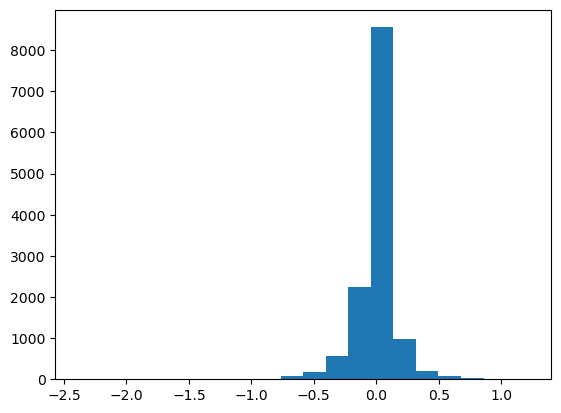

In [49]:
# Plot distribution of differences
plt.hist(df_actual_preds['Diff'],bins=20)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 8.000e+00, 5.000e+00, 5.800e+01, 1.580e+02, 4.950e+02,
        1.965e+03, 8.805e+03, 1.123e+03, 2.160e+02, 7.200e+01, 3.500e+01,
        4.000e+00, 5.000e+00]),
 array([-3.11  , -2.8765, -2.643 , -2.4095, -2.176 , -1.9425, -1.709 ,
        -1.4755, -1.242 , -1.0085, -0.775 , -0.5415, -0.308 , -0.0745,
         0.159 ,  0.3925,  0.626 ,  0.8595,  1.093 ,  1.3265,  1.56  ]),
 <BarContainer object of 20 artists>)

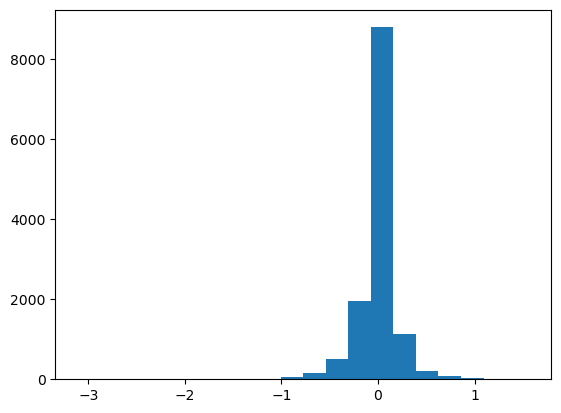

In [50]:
# Plot distribution of %difference
plt.hist(df_actual_preds['%Diff'],bins=20)

### Overall Predictions vs. Actual Prices

[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

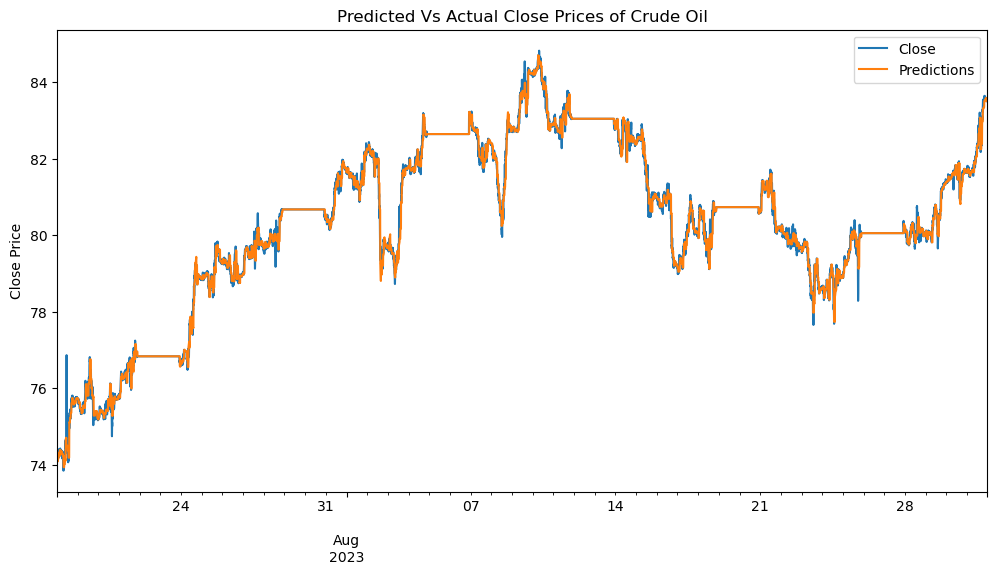

In [51]:
# Plot predictions against known values
title = 'Predicted Vs Actual Close Prices of Crude Oil'
ylabel='Close Price'
xlabel='' 

ax = df_actual_preds['Close'].plot(legend=True,figsize=(12,6),title=title)
df_actual_preds['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### One Month Close-up

[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

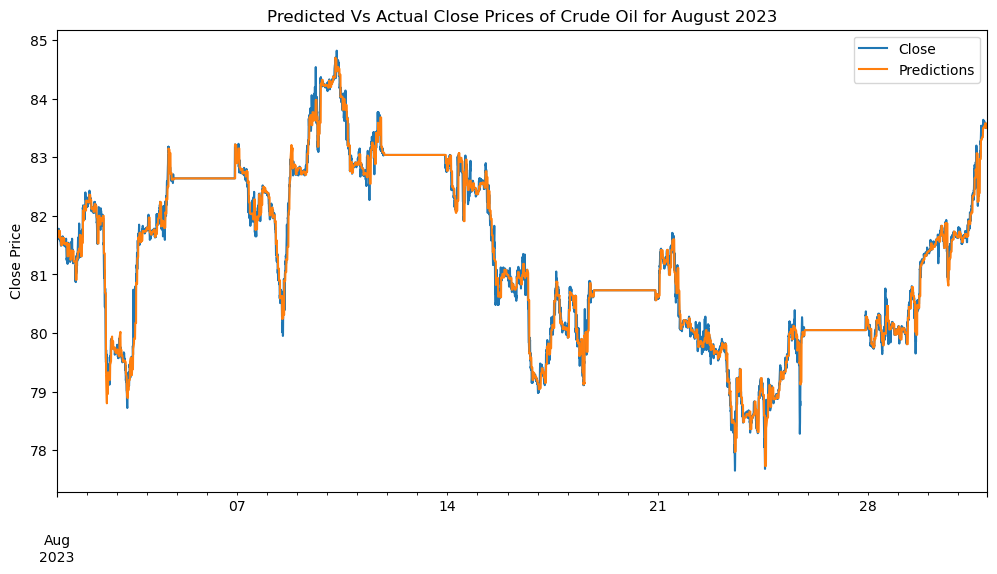

In [52]:
# Make a plot for the month of August
start = '2023-08-01 00:00:00'
end = '2023-08-31 23:55:00'

title = 'Predicted Vs Actual Close Prices of Crude Oil for August 2023'
ylabel='Close Price'
xlabel='' 

ax = df_actual_preds[start:end]['Close'].plot(legend=True,figsize=(12,6),title=title)
df_actual_preds[start:end]['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### 5-Day Close-up 

[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

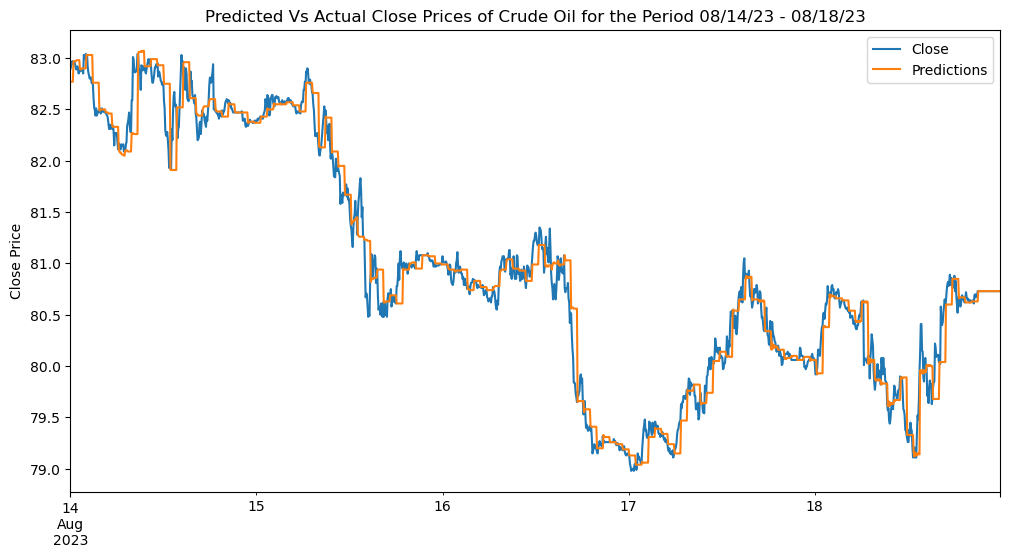

In [53]:
# Make a plot for 5-days from 08/14/23 - 08/18/23
start = '2023-08-14 00:00:00'
end = '2023-08-18 23:55:00'

title = 'Predicted Vs Actual Close Prices of Crude Oil for the Period 08/14/23 - 08/18/23'
ylabel='Close Price'
xlabel='' 

ax = df_actual_preds[start:end]['Close'].plot(legend=True,figsize=(12,6),title=title)
df_actual_preds[start:end]['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

### One Day Close-up

[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

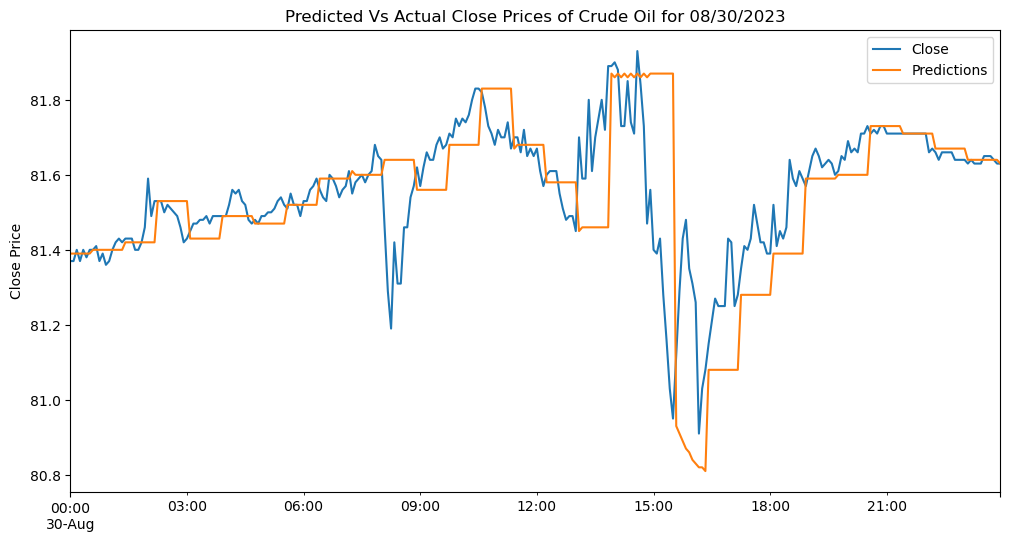

In [54]:
# Make a plot for the 30th of August
start = '2023-08-30 00:00:00'
end = '2023-08-30 23:55:00'

# Plot predictions against known values
title = 'Predicted Vs Actual Close Prices of Crude Oil for 08/30/2023'
ylabel='Close Price'
xlabel='' 

ax = df_actual_preds[start:end]['Close'].plot(legend=True,figsize=(12,6),title=title)
df_actual_preds[start:end]['Predictions'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

## 8.5 Future Forecast 

### Make Forecast

In [55]:
# Make Forecast
%timeit

start = train_length
end = train_length + test_span - 1

last_training_set = df.iloc[-train_length:]['Close']
    
model = SARIMAX(last_training_set,order=(2,1,1))
arima_results = model.fit()
    
close_forecast = np.round(arima_results.predict(start=start, end=end, dynamic=False, type='levels'),2)

# Measure the time
start_time = time.time()


print(close_forecast)
print("--- %s seconds ---" % (time.time() - start_time))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33163D+00    |proj g|=  1.37996D-01

At iterate    5    f= -1.33671D+00    |proj g|=  1.04056D-02

At iterate   10    f= -1.33673D+00    |proj g|=  9.60081D-02

At iterate   15    f= -1.33677D+00    |proj g|=  6.96958D-04

At iterate   20    f= -1.33682D+00    |proj g|=  5.05986D-02

At iterate   25    f= -1.33844D+00    |proj g|=  5.90879D-01

At iterate   30    f= -1.33929D+00    |proj g|=  1.09781D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


### Compare with Actual Prices

RMSE of Close Price predictions:10.56
MAE of Close Price predictions:10.56
MAPE of Close Price predictions:0.1263
R^2 of Close Price predictions:0.0


[Text(0.5, 0, ''), Text(0, 0.5, 'Close Price')]

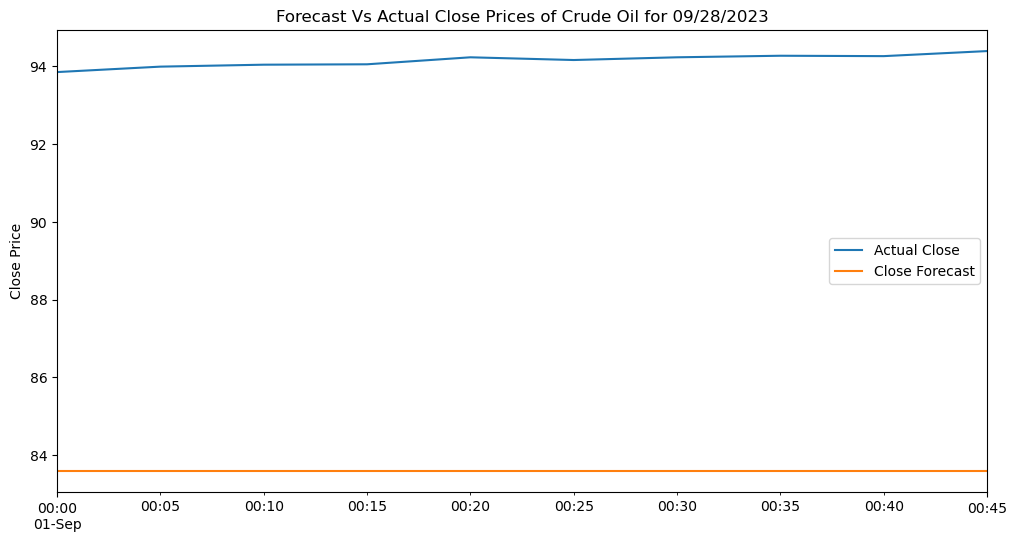

In [56]:
df_forecast = pd.DataFrame(close_forecast)
df_forecast = df_forecast.rename(columns={'predicted_mean':'Close Forecast'})

# Get actual prices
actual_close_data = [93.85, 93.99, 94.04, 94.05, 94.23, 94.16, 94.23, 94.27, 94.26, 94.39]
df_forecast['Actual Close'] = actual_close_data

# Compare forecast with actual prices
df_forecast['Diff'] = df_forecast['Close Forecast']- df_forecast['Actual Close']
df_forecast['%Diff'] = np.round(100*(df_forecast['Close Forecast']- df_forecast['Actual Close'])/df_forecast['Actual Close'],2)
                     

# Find MAE, RMSE, MAPE, R^2 of forecast and actual close price
print('RMSE of Close Price predictions:' + str(np.round(np.sqrt(mean_squared_error(df_forecast['Close Forecast'],df_forecast['Actual Close'])),2)))
print('MAE of Close Price predictions:' + str(np.round(mean_absolute_error(df_forecast['Close Forecast'],df_forecast['Actual Close']),2)))
print('MAPE of Close Price predictions:' + str(np.round(mean_absolute_percentage_error(df_forecast['Close Forecast'],df_forecast['Actual Close']),4)))
print('R^2 of Close Price predictions:' + str(np.round(r2_score(df_forecast['Close Forecast'],df_forecast['Actual Close']),4)))

# Plot Comparison
title = 'Forecast Vs Actual Close Prices of Crude Oil for 09/28/2023'
ylabel='Close Price'
xlabel='' 

ax = df_forecast['Actual Close'].plot(legend=True,figsize=(12,6),title=title)
df_forecast['Close Forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)